## 1. Library Import
- 필요한 라이브러리를 불러옵니다.

In [4]:
!pip install eli5==0.13.0

# 한글 폰트 사용을 위한 라이브러리입니다.
!apt-get install -y fonts-nanum

E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


In [5]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns

# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

import eli5
from eli5.sklearn import PermutationImportance

## 2. Data Load

#### 2.1. 데이터 로드

In [6]:
# 필요한 데이터를 Load 하겠습니다. 경로는 환경에 맞게 지정해주세요 합니다.
train_path = "/home/realtheai/documents/upstage-ml-regression-sigma7/train.csv"
test_path = "/home/realtheai/documents/upstage-ml-regression-sigma7/test.csv"

dt_train = pd.read_csv(train_path)  # train 데이터
dt_test = pd.read_csv(test_path)    # test 데이터

# Train data와 Test data shape을 이렇게 확인합니다.
print('Train data shape : ', dt_train.shape, 'Test data shape : ', dt_test.shape)

Train data shape :  (1118822, 52) Test data shape :  (9272, 51)


In [7]:
# Train data와 Test data shape은 아래와 같습니다.
print('Train data shape : ', dt_train.shape, 'Test data shape : ', dt_test.shape)

Train data shape :  (1118822, 52) Test data shape :  (9272, 51)


## 3. Data Preprocessing

- 모델링 전에 데이터 내 결측치, 이상치 등을 제거하고 범주형과 연속형 변수를 살펴보도록 하겠습니다!
- 먼저, 용이한 전처리를 위해 train과 test data를 합친 하나의 데이터로 진행하도록 하겠습니다.

In [8]:
# train/test 구분을 위한 칼럼을 하나 만들어 줍니다.
dt_train['is_test'] = 0
dt_test['is_test'] = 1
concat = pd.concat([dt_train, dt_test])     # 하나의 데이터로 만들어줍니다.

In [8]:
# train/test 구분을 위한 칼럼을 하나 만들어 줍니다.
dt_train['is_test'] = 0
dt_test['is_test'] = 1
concat = pd.concat([dt_train, dt_test])     # 하나의 데이터로 만들어줍니다.

In [9]:
concat['is_test'].value_counts()      # train과 test data가 하나로 합쳐진 것을 확인할 수 있습니다.

0    1118822
1       9272
Name: is_test, dtype: int64

In [10]:
# 칼럼 이름을 쉽게 바꿔주겠습니다. 다른 칼럼도 사용에 따라 바꿔주셔도 됩니다!
concat = concat.rename(columns={'전용면적(㎡)':'전용면적'})


In [11]:
# 실제로 결측치라고 표시는 안되어있지만 아무 의미도 갖지 않는 element들이 아래와 같이 존재합니다.
# 아래 3가지의 경우 모두 아무 의미도 갖지 않는 element가 포함되어 있습니다.
display(concat['등기신청일자'].value_counts())

            1111271
20230630        585
20230831        496
20230428        394
20230731        374
             ...   
20230105          3
20230125          3
20230109          1
20230102          1
20230104          1
Name: 등기신청일자, Length: 182, dtype: int64

In [12]:
display(concat['거래유형'].value_counts())

-       1086451
중개거래      38123
직거래        3520
Name: 거래유형, dtype: int64

In [13]:
display(concat['중개사소재지'].value_counts())

-                    1090013
서울 노원구                  2627
서울 송파구                  2540
서울 강남구                  2508
서울 강동구                  2038
                      ...   
서울 강북구, 서울 양천구             1
경기 남양주시, 경기 성남수정구          1
서울 송파구, 인천 계양구             1
경기 연천군, 서울 송파구             1
서울 중랑구, 인천 부평구             1
Name: 중개사소재지, Length: 739, dtype: int64

In [15]:
# 위 처럼 아무 의미도 갖지 않는 칼럼은 결측치와 같은 역할을 하므로, np.nan으로 채워 결측치로 인식되도록 합니다.
concat['등기신청일자'] = concat['등기신청일자'].replace(' ', np.nan)
concat['거래유형'] = concat['거래유형'].replace('-', np.nan)
concat['중개사소재지'] = concat['중개사소재지'].replace('-', np.nan)

In [14]:
# EDA에 앞서 결측치를 확인해보겠습니다.
concat.isnull().sum()

시군구                             0
번지                            227
본번                             75
부번                             75
아파트명                         2136
전용면적                            0
계약년월                            0
계약일                             0
층                               0
건축년도                            0
도로명                             0
해제사유발생일                   1121899
등기신청일자                          0
거래유형                            0
중개사소재지                          0
k-단지분류(아파트,주상복합등등)         877273
k-전화번호                     876850
k-팩스번호                     879348
단지소개기존clob                1058958
k-세대타입(분양형태)               876125
k-관리방식                     876125
k-복도유형                     876454
k-난방방식                     876125
k-전체동수                     877207
k-전체세대수                    876125
k-건설사(시공사)                 877637
k-시행사                      877834
k-사용검사일-사용승인일              876259
k-연면적                      876125
k-주거전용면적      

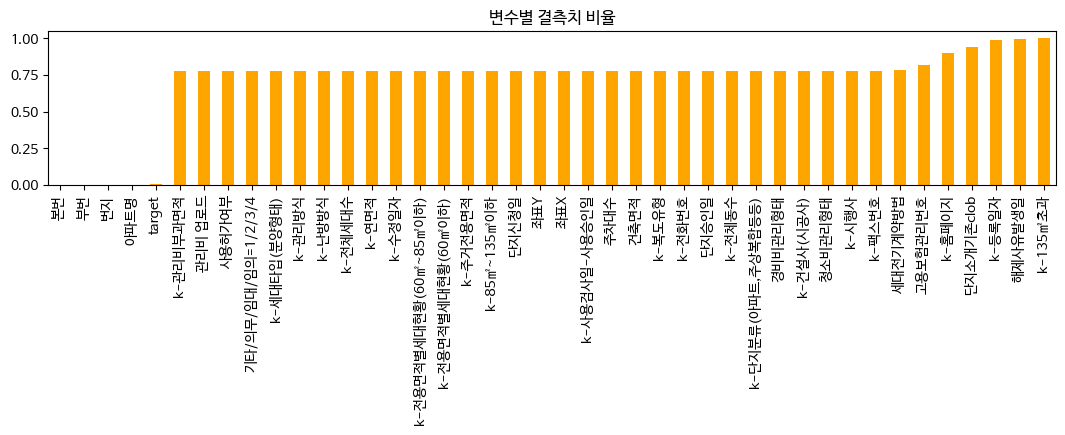

In [15]:
# 변수별 결측치의 비율을 plot으로 그려보면 아래와 같습니다.
fig = plt.figure(figsize=(13, 2))
missing = concat.isnull().sum() / concat.shape[0]
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar(color='orange')
plt.title('변수별 결측치 비율')
plt.show()

- 위 그래프에서 볼 수 있다시피 결측치가 100만개 이상인 칼럼들은 결측치가 해당 칼럼의 element 중 90% 이상을 차지하는 상황이 됩니다.
- 따라서 본 Baseline 에서는 이 칼럼은 예측에 도움이 되지 않는다고 판단해 삭제해주도록 하겠습니다.

In [16]:
# Null값이 100만개 이상인 칼럼은 삭제해보도록 하겠습니다.
print('* 결측치가 100만개 이하인 변수들 :', list(concat.columns[concat.isnull().sum() <= 1000000]))     # 남겨질 변수들은 아래와 같습니다.
print('* 결측치가 100만개 이상인 변수들 :', list(concat.columns[concat.isnull().sum() >= 1000000]))

* 결측치가 100만개 이하인 변수들 : ['시군구', '번지', '본번', '부번', '아파트명', '전용면적', '계약년월', '계약일', '층', '건축년도', '도로명', '등기신청일자', '거래유형', '중개사소재지', 'k-단지분류(아파트,주상복합등등)', 'k-전화번호', 'k-팩스번호', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드', '좌표X', '좌표Y', '단지신청일', 'target', 'is_test']
* 결측치가 100만개 이상인 변수들 : ['해제사유발생일', '단지소개기존clob', 'k-135㎡초과', 'k-홈페이지', 'k-등록일자']


In [17]:
# 위에서 결측치가 100만개 이하인 변수들만 골라 새로운 concat_select 객체로 저장해줍니다.
selected = list(concat.columns[concat.isnull().sum() <= 1000000])
concat_select = concat[selected]

In [18]:
concat_select.isnull().sum()     # 결측치가 100만개 초과인 칼럼이 제거된 모습은 아래와 같습니다.
# target변수는 test dataset 개수만큼(9272) 결측치가 존재함을 확인할 수 있습니다.

시군구                            0
번지                           227
본번                            75
부번                            75
아파트명                        2136
전용면적                           0
계약년월                           0
계약일                            0
층                              0
건축년도                           0
도로명                            0
등기신청일자                         0
거래유형                           0
중개사소재지                         0
k-단지분류(아파트,주상복합등등)        877273
k-전화번호                    876850
k-팩스번호                    879348
k-세대타입(분양형태)              876125
k-관리방식                    876125
k-복도유형                    876454
k-난방방식                    876125
k-전체동수                    877207
k-전체세대수                   876125
k-건설사(시공사)                877637
k-시행사                     877834
k-사용검사일-사용승인일             876259
k-연면적                     876125
k-주거전용면적                  876170
k-관리비부과면적                 876125
k-전용면적별세대현황(60㎡이하)        876170
k-전용면적별세대현

In [19]:
# 연속형 변수는 선형보간을 해주고, 범주형변수는 알수없기에 “unknown”이라고 임의로 보간해 주겠습니다.
concat_select.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1128094 entries, 0 to 9271
Data columns (total 48 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   시군구                     1128094 non-null  object 
 1   번지                      1127867 non-null  object 
 2   본번                      1128019 non-null  float64
 3   부번                      1128019 non-null  float64
 4   아파트명                    1125958 non-null  object 
 5   전용면적                    1128094 non-null  float64
 6   계약년월                    1128094 non-null  int64  
 7   계약일                     1128094 non-null  int64  
 8   층                       1128094 non-null  int64  
 9   건축년도                    1128094 non-null  int64  
 10  도로명                     1128094 non-null  object 
 11  등기신청일자                  1128094 non-null  object 
 12  거래유형                    1128094 non-null  object 
 13  중개사소재지                  1128094 non-null  object 
 14  k-단지분

In [20]:
# 본번, 부번의 경우 float로 되어있지만 범주형 변수의 의미를 가지므로 object(string) 형태로 바꾸어주고 아래 작업을 진행하겠습니다.
concat_select['본번'] = concat_select['본번'].astype('str')
concat_select['부번'] = concat_select['부번'].astype('str')

In [21]:
# 먼저, 연속형 변수와 범주형 변수를 위 info에 따라 분리해주겠습니다.
continuous_columns = []
categorical_columns = []

for column in concat_select.columns:
    if pd.api.types.is_numeric_dtype(concat_select[column]):
        continuous_columns.append(column)
    else:
        categorical_columns.append(column)

print("연속형 변수:", continuous_columns)
print("범주형 변수:", categorical_columns)

연속형 변수: ['전용면적', '계약년월', '계약일', '층', '건축년도', 'k-전체동수', 'k-전체세대수', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', '건축면적', '주차대수', '좌표X', '좌표Y', 'target', 'is_test']
범주형 변수: ['시군구', '번지', '본번', '부번', '아파트명', '도로명', '등기신청일자', '거래유형', '중개사소재지', 'k-단지분류(아파트,주상복합등등)', 'k-전화번호', 'k-팩스번호', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일', 'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드', '단지신청일']


- 연속형 변수와 범주형 변수가 알맞게 나누어졌는지 확인해보고, 이제 각각 보간을 진행합니다.

In [22]:
# 개선된 결측치 처리 방법
# 범주형 변수의 결측치를 최빈값으로 대체 (좀더 유의미)
for col in categorical_columns:
    if concat_select[col].isnull().sum() > 0:
        mode_value = concat_select[col].mode()
        if len(mode_value) > 0:
            concat_select[col].fillna(mode_value[0], inplace=True)
        else:
            # 최빈값이 없는 경우에만 'NULL'로 대체
            concat_select[col].fillna('NULL', inplace=True)

# 연속형 변수의 결측치를 그룹별 평균/중앙값으로 대체 (좀더 정확)
for col in continuous_columns:
    if concat_select[col].isnull().sum() > 0:
        # 시군구별 그룹 평균으로 대체 (지역별 특성 반영)
        if '시군구' in concat_select.columns:
            concat_select[col] = concat_select.groupby('시군구')[col].transform(
                lambda x: x.fillna(x.median())
            )
        # 여전히 결측값이 있다면 전체 중앙값으로 대체
        if concat_select[col].isnull().sum() > 0:
            concat_select[col].fillna(concat_select[col].median(), inplace=True)

In [23]:
concat_select.isnull().sum()         # 결측치가 보간된 모습을 확인해봅니다.

시군구                       0
번지                        0
본번                        0
부번                        0
아파트명                      0
전용면적                      0
계약년월                      0
계약일                       0
층                         0
건축년도                      0
도로명                       0
등기신청일자                    0
거래유형                      0
중개사소재지                    0
k-단지분류(아파트,주상복합등등)        0
k-전화번호                    0
k-팩스번호                    0
k-세대타입(분양형태)              0
k-관리방식                    0
k-복도유형                    0
k-난방방식                    0
k-전체동수                    0
k-전체세대수                   0
k-건설사(시공사)                0
k-시행사                     0
k-사용검사일-사용승인일             0
k-연면적                     0
k-주거전용면적                  0
k-관리비부과면적                 0
k-전용면적별세대현황(60㎡이하)        0
k-전용면적별세대현황(60㎡~85㎡이하)    0
k-85㎡~135㎡이하              0
k-수정일자                    0
고용보험관리번호                  0
경비비관리형태                   0
세대전기계약방법            

- Baseline에서는 단순 결측치들을 제거하거나 보간했지만,
EDA를 통해 변수들의 흐름을 조금 더 파악하고 더 나은 interpolation 등의 방법을 고려해볼 수 있을 것 같습니다.

### 3.2. 이상치 처리
- 이번엔 이상치를 처리해봅시다.
- 이상치를 처리하는 방법은 IQR, Z-score 등 다양한 방법이 있습니다. 가장 쉽고 직관적으로 접근하는 방법은 기본 통계치를 이용하는 것입니다.
- 본 baseline에서는 IQR를 이용한 방법을 사용하겠습니다.

In [24]:
# 이상치 제거 이전의 shape은 아래와 같습니다.
print(concat_select.shape)

(1128094, 48)


In [25]:
# 데이터 변환을 위한 라이브러리 추가
from scipy import stats
from scipy.stats import boxcox
import warnings
warnings.filterwarnings('ignore')

# 연속형 변수들의 왜도(skewness) 확인
print("=== 연속형 변수들의 왜도 분석 ===")
skewness_data = []

for col in continuous_columns:
    if col not in ['target', 'is_test'] and concat_select[col].nunique() > 10:
        skew_val = concat_select[col].skew()
        skewness_data.append({
            'variable': col,
            'skewness': skew_val,
            'abs_skewness': abs(skew_val)
        })

# 왜도 기준으로 정렬
skewness_df = pd.DataFrame(skewness_data).sort_values('abs_skewness', ascending=False)
print(skewness_df.head(10))

# 왜도가 심한 변수들 (절댓값 > 1.0) 확인
high_skew_vars = skewness_df[skewness_df['abs_skewness'] > 1.0]['variable'].tolist()
print(f"\n왜도가 심한 변수들 (|skewness| > 1.0): {len(high_skew_vars)}개")
print(high_skew_vars)


=== 연속형 변수들의 왜도 분석 ===
                  variable   skewness  abs_skewness
13                    건축면적  19.734509     19.734509
7                    k-연면적   4.702542      4.702542
11  k-전용면적별세대현황(60㎡~85㎡이하)   4.622848      4.622848
5                   k-전체동수   4.354051      4.354051
10      k-전용면적별세대현황(60㎡이하)   3.620012      3.620012
12            k-85㎡~135㎡이하   3.191328      3.191328
9                k-관리비부과면적   2.959602      2.959602
8                 k-주거전용면적   2.948739      2.948739
14                    주차대수   2.881519      2.881519
6                  k-전체세대수   2.568501      2.568501

왜도가 심한 변수들 (|skewness| > 1.0): 12개
['건축면적', 'k-연면적', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-전체동수', 'k-전용면적별세대현황(60㎡이하)', 'k-85㎡~135㎡이하', 'k-관리비부과면적', 'k-주거전용면적', '주차대수', 'k-전체세대수', '전용면적', '층']


In [26]:
# 데이터 변환 함수 정의
def apply_transformations(data, columns_to_transform):
    """
    왜도가 심한 변수들에 대해 다양한 변환 기법을 적용하고 
    가장 적합한 변환을 선택합니다.
    """
    transformed_data = data.copy()
    transformation_log = []
    
    for col in columns_to_transform:
        if col in transformed_data.columns:
            original_skew = abs(transformed_data[col].skew())
            
            # 음수값이 있는 경우 최소값만큼 이동
            min_val = transformed_data[col].min()
            if min_val <= 0:
                shift_value = abs(min_val) + 1
                shifted_col = transformed_data[col] + shift_value
            else:
                shifted_col = transformed_data[col]
                shift_value = 0
            
            transformations = {}
            
            # 1. 로그 변환
            try:
                log_transformed = np.log(shifted_col)
                log_skew = abs(log_transformed.skew())
                transformations['log'] = {'data': log_transformed, 'skewness': log_skew}
            except:
                pass
            
            # 2. 제곱근 변환  
            try:
                sqrt_transformed = np.sqrt(shifted_col)
                sqrt_skew = abs(sqrt_transformed.skew())
                transformations['sqrt'] = {'data': sqrt_transformed, 'skewness': sqrt_skew}
            except:
                pass
            
            # 3. Box-Cox 변환 (양수인 경우에만)
            try:
                if (shifted_col > 0).all():
                    boxcox_transformed, lambda_val = boxcox(shifted_col)
                    boxcox_skew = abs(pd.Series(boxcox_transformed).skew())
                    transformations['boxcox'] = {
                        'data': pd.Series(boxcox_transformed), 
                        'skewness': boxcox_skew,
                        'lambda': lambda_val
                    }
            except:
                pass
            
            # 가장 좋은 변환 선택 (왜도가 가장 낮은 것)
            if transformations:
                best_transform = min(transformations.keys(), 
                                   key=lambda x: transformations[x]['skewness'])
                
                # 원래 왜도보다 개선된 경우에만 적용
                if transformations[best_transform]['skewness'] < original_skew:
                    transformed_data[col] = transformations[best_transform]['data']
                    transformation_log.append({
                        'variable': col,
                        'original_skewness': original_skew,
                        'transformation': best_transform,
                        'new_skewness': transformations[best_transform]['skewness'],
                        'improvement': original_skew - transformations[best_transform]['skewness'],
                        'shift_value': shift_value
                    })
                else:
                    transformation_log.append({
                        'variable': col,
                        'original_skewness': original_skew,
                        'transformation': 'none',
                        'new_skewness': original_skew,
                        'improvement': 0,
                        'shift_value': 0
                    })
    
    return transformed_data, transformation_log

# 변환 적용
print("=== 데이터 변환 적용 중... ===")
concat_transformed, transform_log = apply_transformations(concat_select, high_skew_vars)

# 변환 결과 출력
transform_df = pd.DataFrame(transform_log)
print("\n=== 변환 결과 ===")
print(transform_df[transform_df['transformation'] != 'none'])


=== 데이터 변환 적용 중... ===

=== 변환 결과 ===
                  variable  original_skewness transformation  new_skewness  \
0                     건축면적          19.734509         boxcox      0.044206   
1                    k-연면적           4.702542         boxcox      0.279418   
2   k-전용면적별세대현황(60㎡~85㎡이하)           4.622848         boxcox      0.022631   
3                   k-전체동수           4.354051         boxcox      0.002359   
4       k-전용면적별세대현황(60㎡이하)           3.620012         boxcox      0.123400   
5             k-85㎡~135㎡이하           3.191328         boxcox      0.048971   
6                k-관리비부과면적           2.959602         boxcox      0.270318   
7                 k-주거전용면적           2.948739         boxcox      0.003160   
8                     주차대수           2.881519         boxcox      0.023842   
9                  k-전체세대수           2.568501         boxcox      0.036276   
10                    전용면적           1.252310         boxcox      0.076289   
11                       층

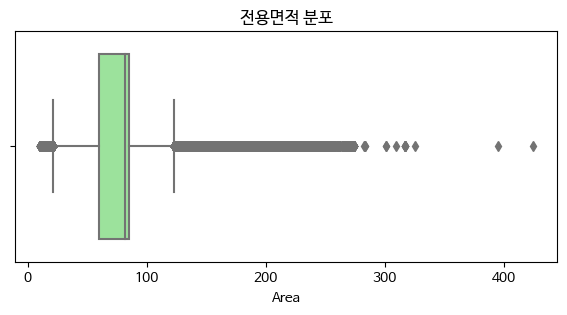

In [27]:
# 대표적인 연속형 변수인 “전용 면적” 변수 관련한 분포를 먼저 살펴보도록 하겠습니다.
fig = plt.figure(figsize=(7, 3))
sns.boxplot(data = concat_select, x = '전용면적', color='lightgreen')
plt.title('전용면적 분포')
plt.xlabel('Area')
plt.show()

In [28]:


# 이상치 제거 방법에는 IQR을 이용하겠습니다.
# Train 데이터에만 적용하고 Test 데이터는 보존합니다.
def remove_outliers_iqr(df, column):
    # train 데이터와 test 데이터 분리
    train_mask = df['is_test'] == 0
    test_mask = df['is_test'] == 1
    
    train_data = df[train_mask].copy()
    test_data = df[test_mask].copy()
    
    print(f"이상치 제거 전:")
    print(f"  - Train 데이터 크기: {train_data.shape}")
    print(f"  - Test 데이터 크기: {test_data.shape}")
    print(f"  - 전체 데이터 크기: {df.shape}")
    
    # train 데이터에서만 이상치 계산
    Q1 = train_data[column].quantile(0.25)
    Q3 = train_data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    print(f"\n{column} 컬럼 이상치 기준:")
    print(f"  - Q1 (25%): {Q1:.2f}")
    print(f"  - Q3 (75%): {Q3:.2f}")
    print(f"  - IQR: {IQR:.2f}")
    print(f"  - 하한선: {lower_bound:.2f}")
    print(f"  - 상한선: {upper_bound:.2f}")
    
    # train 데이터에서만 이상치 제거
    outlier_mask = (train_data[column] < lower_bound) | (train_data[column] > upper_bound)
    train_filtered = train_data[~outlier_mask]
    
    # 데이터 다시 합치기 (test 데이터는 그대로 유지)
    result_df = pd.concat([train_filtered, test_data], ignore_index=True)
    
    print(f"\n이상치 제거 후:")
    print(f"  - Train 데이터 크기: {train_filtered.shape}")
    print(f"  - Test 데이터 크기: {test_data.shape}")
    print(f"  - 전체 데이터 크기: {result_df.shape}")
    print(f"  - 제거된 이상치 개수: {outlier_mask.sum()}개")
    
    return result_df

In [29]:
# 위 방법으로 전용 면적에 대한 이상치를 제거해보겠습니다.
concat_select = remove_outliers_iqr(concat_select, '전용면적')

이상치 제거 전:
  - Train 데이터 크기: (1118822, 48)
  - Test 데이터 크기: (9272, 48)
  - 전체 데이터 크기: (1128094, 48)

전용면적 컬럼 이상치 기준:
  - Q1 (25%): 59.65
  - Q3 (75%): 84.96
  - IQR: 25.31
  - 하한선: 21.69
  - 상한선: 122.92

이상치 제거 후:
  - Train 데이터 크기: (1029574, 48)
  - Test 데이터 크기: (9272, 48)
  - 전체 데이터 크기: (1038846, 48)
  - 제거된 이상치 개수: 89248개


In [30]:
# 이상치 제거 후의 shape은 아래와 같습니다. 약 10만개의 데이터가 제거된 모습을 확인할 수 있습니다.
print(concat_select.shape)

(1038846, 48)


In [31]:
concat_select['is_test'].value_counts()     # 또한, train data만 제거되었습니다.

0    1029574
1       9272
Name: is_test, dtype: int64

## 4. Feature Engineering
- 이제 파생변수를 만들어보도록 하겠습니다.
- 파생 변수는 도메인 지식에 기반해 제작하는 것이 중요합니다.
- 주택의 가격을 예측하는 문제이기 때문에 약간의 부동산 지식을 기반으로 파생 변수를 만들어 보도록 하겠습니다.

In [32]:
concat_select['시군구'].head()

0    서울특별시 강남구 개포동
1    서울특별시 강남구 개포동
2    서울특별시 강남구 개포동
3    서울특별시 강남구 개포동
4    서울특별시 강남구 개포동
Name: 시군구, dtype: object

In [33]:
# 지하철역 데이터 로드
subway_path = "/home/realtheai/documents/upstage-ml-regression-sigma7/subway_feature.csv"
subway_data = pd.read_csv(subway_path)
print(f"지하철역 데이터: {subway_data.shape}")


지하철역 데이터: (768, 5)


In [34]:
# 거리 계산 함수
import math
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    return R * 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))


In [36]:
# 지하철 접근성 파생 변수 생성 (미터 단위로 수정된 버전)
def add_subway_features(df, subway_df):
    print("지하철 접근성 변수 생성 중... (미터 단위 출력)")
    
    # 유효한 좌표가 있는 데이터 필터링
    valid_mask = df[['좌표Y', '좌표X']].notna().all(axis=1)
    subway_valid = subway_df[['위도', '경도']].notna().all(axis=1)
    
    # 결과 컬럼 초기화
    df['subway_min_distance'] = np.nan
    df['nearest_subway_line'] = 'Unknown'
    
    if valid_mask.sum() == 0 or subway_valid.sum() == 0:
        print("유효한 좌표 데이터가 없습니다.")
        return df
    
    print(f"처리할 부동산 데이터: {valid_mask.sum():,}개")
    print(f"사용 가능한 지하철역: {subway_valid.sum()}개")
    
    # 지하철역 좌표와 호선 정보 추출
    subway_coords = subway_df[subway_valid][['위도', '경도']].values
    subway_lines = subway_df[subway_valid]['호선'].fillna('Unknown').astype(str).values
    
    # 부동산 좌표 추출
    property_coords = df[valid_mask][['좌표Y', '좌표X']].values
    
    # 배치 크기 설정 (메모리 사용량 제한)
    batch_size = 5000
    
    for i in range(0, len(property_coords), batch_size):
        end_idx = min(i + batch_size, len(property_coords))
        batch_coords = property_coords[i:end_idx]
        
        # 현재 배치에 대한 인덱스
        batch_indices = df[valid_mask].index[i:end_idx]
        
        print(f"진행률: {i+len(batch_coords)}/{len(property_coords)} ({((i+len(batch_coords))/len(property_coords)*100):.1f}%)")
        
        # 벡터화된 거리 계산
        # 각 부동산에 대해 모든 지하철역과의 거리를 한번에 계산
        distances_matrix = np.zeros((len(batch_coords), len(subway_coords)))
        
        for j, (prop_lat, prop_lon) in enumerate(batch_coords):
            # 모든 지하철역과의 거리를 벡터화로 계산
            lat1_rad = np.radians(prop_lat)
            lon1_rad = np.radians(prop_lon)
            lat2_rad = np.radians(subway_coords[:, 0])
            lon2_rad = np.radians(subway_coords[:, 1])
            
            dlat = lat2_rad - lat1_rad
            dlon = lon2_rad - lon1_rad
            
            a = np.sin(dlat/2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon/2)**2
            c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
            # 수정: 6371.0 * c * 1000 으로 바로 미터 단위 계산
            distances_matrix[j] = 6371.0 * c * 1000  # km -> m 변환
        
        # 각 부동산에 대해 가장 가까운 지하철역 찾기
        min_indices = np.argmin(distances_matrix, axis=1)
        min_distances = distances_matrix[np.arange(len(batch_coords)), min_indices]
        nearest_lines = subway_lines[min_indices]
        
        # 결과 저장 (이미 미터 단위)
        df.loc[batch_indices, 'subway_min_distance'] = min_distances
        df.loc[batch_indices, 'nearest_subway_line'] = nearest_lines
    
    print("지하철 접근성 변수 생성 완료! (미터 단위)")
    print(f"거리 범위: {df['subway_min_distance'].min():.1f}m ~ {df['subway_min_distance'].max():.1f}m")
    return df

In [37]:
# 지하철 접근성 파생 변수 적용
concat_select = add_subway_features(concat_select, subway_data)

print(f"최종 데이터 크기: {concat_select.shape}")
print(f"지하철 거리 - 평균: {concat_select['subway_min_distance'].mean():.2f}km")
print("지하철 접근성 파생 변수 생성 완료!")


지하철 접근성 변수 생성 중... (미터 단위 출력)
처리할 부동산 데이터: 1,038,846개
사용 가능한 지하철역: 768개
진행률: 5000/1038846 (0.5%)
진행률: 10000/1038846 (1.0%)
진행률: 15000/1038846 (1.4%)
진행률: 20000/1038846 (1.9%)
진행률: 25000/1038846 (2.4%)
진행률: 30000/1038846 (2.9%)
진행률: 35000/1038846 (3.4%)
진행률: 40000/1038846 (3.9%)
진행률: 45000/1038846 (4.3%)
진행률: 50000/1038846 (4.8%)
진행률: 55000/1038846 (5.3%)
진행률: 60000/1038846 (5.8%)
진행률: 65000/1038846 (6.3%)
진행률: 70000/1038846 (6.7%)
진행률: 75000/1038846 (7.2%)
진행률: 80000/1038846 (7.7%)
진행률: 85000/1038846 (8.2%)
진행률: 90000/1038846 (8.7%)
진행률: 95000/1038846 (9.1%)
진행률: 100000/1038846 (9.6%)
진행률: 105000/1038846 (10.1%)
진행률: 110000/1038846 (10.6%)
진행률: 115000/1038846 (11.1%)
진행률: 120000/1038846 (11.6%)
진행률: 125000/1038846 (12.0%)
진행률: 130000/1038846 (12.5%)
진행률: 135000/1038846 (13.0%)
진행률: 140000/1038846 (13.5%)
진행률: 145000/1038846 (14.0%)
진행률: 150000/1038846 (14.4%)
진행률: 155000/1038846 (14.9%)
진행률: 160000/1038846 (15.4%)
진행률: 165000/1038846 (15.9%)
진행률: 170000/1038846 (16.4%)
진행률: 175000/1038

In [38]:
concat_select['계약년월'].head()

0    201712
1    201712
2    201712
3    201801
4    201801
Name: 계약년월, dtype: int64

In [39]:
# 시군구, 년월 등 분할할 수 있는 변수들은 세부사항 고려를 용이하게 하기 위해 모두 분할해 주겠습니다.
concat_select['구'] = concat_select['시군구'].map(lambda x : x.split()[1])
concat_select['동'] = concat_select['시군구'].map(lambda x : x.split()[2])
del concat_select['시군구']

concat_select['계약년'] = concat_select['계약년월'].astype('str').map(lambda x : x[:4])
concat_select['계약월'] = concat_select['계약년월'].astype('str').map(lambda x : x[4:])
del concat_select['계약년월']

In [40]:
concat_select.columns

Index(['번지', '본번', '부번', '아파트명', '전용면적', '계약일', '층', '건축년도', '도로명', '등기신청일자',
       '거래유형', '중개사소재지', 'k-단지분류(아파트,주상복합등등)', 'k-전화번호', 'k-팩스번호',
       'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-전체동수', 'k-전체세대수',
       'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일', 'k-연면적', 'k-주거전용면적',
       'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)',
       'k-85㎡~135㎡이하', 'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태',
       '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드',
       '좌표X', '좌표Y', '단지신청일', 'target', 'is_test', 'subway_min_distance',
       'nearest_subway_line', '구', '동', '계약년', '계약월'],
      dtype='object')

- 서울의 집값은 강남, 강북 여부에 따라 차이가 많이 난다는 사실은 많이 알려진 사실입니다.
- 따라서 강남/강북의 여부에 따라 파생변수를 생성해주도록 하겠습니다.

In [41]:
all = list(concat_select['구'].unique())
gangnam = ['강서구', '영등포구', '동작구', '서초구', '강남구', '송파구', '강동구']
gangbuk = [x for x in all if x not in gangnam]

assert len(all) == len(gangnam) + len(gangbuk)       # 알맞게 분리되었는지 체크합니다.

In [42]:
# 강남의 여부를 체크합니다.
is_gangnam = []
for x in concat_select['구'].tolist() :
  if x in gangnam :
    is_gangnam.append(1)
  else :
    is_gangnam.append(0)

# 파생변수를 하나 만릅니다.
concat_select['강남여부'] = is_gangnam

In [43]:
concat_select[['subway_min_distance', 'nearest_subway_line']]

,subway_min_distance,nearest_subway_line
0,1129.774800,분당선
1,1129.774800,분당선
2,1129.774800,분당선
3,1129.774800,분당선
4,1129.774800,분당선
...,...,...
1038841,733.290902,경춘선
1038842,733.290902,경춘선
1038843,733.290902,경춘선
1038844,733.290902,경춘선


In [44]:
def add_line_grade(df):
    """호선별 등급 점수 추가 (2023년 6월 기준)"""
    
    # 호선별 등급 매핑
    line_grade_map = {
        # S급 = 5점
        "신분당선": 5, "신분당선(연장)": 5, "신분당선(연장2)": 5, "3호선": 5,
        # A급 = 4점  
        "2호선": 4, "7호선": 4, "분당선": 4, "9호선": 4,
        # B급 = 3점
        "1호선": 3, "4호선": 3, "5호선": 3, "6호선": 3, "8호선": 3, "9호선(연장)": 3,
        # C급 = 2점
        "중앙선": 2, "경의중앙선": 2, "경춘선": 2, "경원선": 2, "경인선": 2, "일산선": 2,
        "과천선": 2, "안산선": 2, "수인선": 2, "인천1호선": 2, "인천2호선": 2, 
        "7호선(인천)": 2, "공항철도1호선": 2, "우이신설선": 2, "신림선": 2,
        # D급 = 1점
        "에버라인선": 1, "의정부선": 1, "경부선": 1, "서해선": 1, "경강선": 1,
        "김포골드라인": 1, "장항선": 1, "진접선": 1
    }
    
    # 호선 등급 컬럼 추가
    df['호선등급'] = df['nearest_subway_line'].map(line_grade_map).fillna(0)
    
    print(f"호선 등급 추가 완료! (평균: {df['호선등급'].mean():.2f}점)")
    return df

# 호선등급 컬럼 추가
concat_select = add_line_grade(concat_select)

호선 등급 추가 완료! (평균: 3.39점)


In [45]:
concat_select['호선등급'] if '호선등급' in concat_select.columns else print("호선등급 컬럼이 없습니다")

0          4
1          4
2          4
3          4
4          4
          ..
1038841    2
1038842    2
1038843    2
1038844    2
1038845    2
Name: 호선등급, Length: 1038846, dtype: int64

In [46]:

def add_station_area_grade(df):
    """
    지하철역까지의 최단거리를 역세권 등급으로 분류
    - S급 (초역세권): 250m 이하 - 5점
    - A급 (1차 역세권): 250m 초과 ~ 500m 이하 - 4점 
    - B급 (2차 역세권): 500m 초과 ~ 800m 이하 - 3점
    - C급 (간접 역세권): 800m 초과 ~ 1200m 이하 - 2점
    - D급 (비역세권): 1200m 초과 - 1점
    """
    if 'subway_min_distance' not in df.columns:
        print("subway_min_distance 컬럼이 없습니다.")
        return df
    
    # 역세권 컬럼 초기화
    df['역세권'] = 1  # 기본값 1점 (D급 - 비역세권)
    
    # 등급 분류
    df.loc[df['subway_min_distance'] <= 250, '역세권'] = 5   # S급: 250m 이하
    df.loc[(df['subway_min_distance'] > 250) & (df['subway_min_distance'] <= 500), '역세권'] = 4   # A급: 250m~500m
    df.loc[(df['subway_min_distance'] > 500) & (df['subway_min_distance'] <= 800), '역세권'] = 3   # B급: 500m~800m
    df.loc[(df['subway_min_distance'] > 800) & (df['subway_min_distance'] <= 1200), '역세권'] = 2  # C급: 800m~1200m
    # 1200m 초과는 이미 1점(D급)으로 설정됨
    
    print("역세권 등급 분류 완료!")
    return df

# 함수 적용
concat_select = add_station_area_grade(concat_select)

# 결과 확인
print("\n=== 역세권 등급 분포 ===")
grade_counts = concat_select['역세권'].value_counts().sort_index()
grade_labels = {5: 'S급(초역세권)', 4: 'A급(1차역세권)', 3: 'B급(2차역세권)', 2: 'C급(간접역세권)', 1: 'D급(비역세권)'}

for grade in sorted(grade_counts.index):
    count = grade_counts[grade]
    percentage = (count / len(concat_select)) * 100
    print(f"{grade}점 - {grade_labels[grade]}: {count:,}개 ({percentage:.1f}%)")

# 등급별 거리 통계
print("\n=== 등급별 거리 통계 ===")
distance_stats = concat_select.groupby('역세권')['subway_min_distance'].agg(['count', 'min', 'max', 'mean']).round(1)
distance_stats.index = [f"{idx}점({grade_labels[idx]})" for idx in distance_stats.index]
print(distance_stats)

역세권 등급 분류 완료!

=== 역세권 등급 분포 ===
1점 - D급(비역세권): 34,564개 (3.3%)
2점 - C급(간접역세권): 117,248개 (11.3%)
3점 - B급(2차역세권): 300,467개 (28.9%)
4점 - A급(1차역세권): 487,495개 (46.9%)
5점 - S급(초역세권): 99,072개 (9.5%)

=== 등급별 거리 통계 ===
                count     min     max    mean
1점(D급(비역세권))    34564  1208.4  2510.7  1442.2
2점(C급(간접역세권))  117248   800.6  1194.9   962.2
3점(B급(2차역세권))  300467   500.4   793.6   636.9
4점(A급(1차역세권))  487495   250.3   498.2   379.5
5점(S급(초역세권))    99072    36.2   248.8   184.6


In [47]:
concat_select['역세권']

0          2
1          2
2          2
3          2
4          2
          ..
1038841    3
1038842    3
1038843    3
1038844    3
1038845    3
Name: 역세권, Length: 1038846, dtype: int64

In [48]:
concat_select.columns

Index(['번지', '본번', '부번', '아파트명', '전용면적', '계약일', '층', '건축년도', '도로명', '등기신청일자',
       '거래유형', '중개사소재지', 'k-단지분류(아파트,주상복합등등)', 'k-전화번호', 'k-팩스번호',
       'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-전체동수', 'k-전체세대수',
       'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일', 'k-연면적', 'k-주거전용면적',
       'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)',
       'k-85㎡~135㎡이하', 'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태',
       '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드',
       '좌표X', '좌표Y', '단지신청일', 'target', 'is_test', 'subway_min_distance',
       'nearest_subway_line', '구', '동', '계약년', '계약월', '강남여부', '호선등급', '역세권'],
      dtype='object')

- 또한 신축인지, 구축인지의 여부도 실거래가에 큰 영향을 줄 수 있습니다.
- 따라서 건축년도에 따라 파생변수를 제작해주도록 하겠습니다.

In [49]:
# 건축년도 분포는 아래와 같습니다. 특히 2005년이 Q3에 해당합니다.
# 2009년 이후에 지어진 건물은 10%정도 되는 것을 확인할 수 있습니다.
concat_select['건축년도'].describe(percentiles = [0.1, 0.25, 0.5, 0.75, 0.8, 0.9])

count    1.038846e+06
mean     1.998583e+03
std      9.132471e+00
min      1.961000e+03
10%      1.987000e+03
25%      1.992000e+03
50%      2.000000e+03
75%      2.005000e+03
80%      2.006000e+03
90%      2.009000e+03
max      2.023000e+03
Name: 건축년도, dtype: float64

In [50]:
# 따라서 2009년 이후에 지어졌으면 비교적 신축이라고 판단하고, 신축 여부 변수를 제작해보도록 하겠습니다.
concat_select['신축여부'] = concat_select['건축년도'].apply(lambda x: 1 if x >= 2009 else 0)

In [51]:


# 🚀 초고속 학업성과 Feature 생성 함수 (벡터화 최적화) - 10개 Feature 버전
def add_school_features_fast(df, school_df):
    """
    학교 데이터를 기반으로 학업성과 관련 Feature 생성 (초고속 버전)
    10개 Feature: 거리(2) + 점수(2) + 등급(2) + 1km내개수(1) + 1km내평균점수(1) + 진학률(2)
    """
    print("🚀 초고속 학업성과 Feature 생성 중... (10개 Feature)")
    
    # 유효한 좌표가 있는 데이터 필터링
    valid_mask = df[['좌표Y', '좌표X']].notna().all(axis=1)
    school_valid = school_df[['위도', '경도']].notna().all(axis=1)
    
    # 결과 컬럼 초기화 (10개 Feature)
    feature_columns = [
        'nearest_middle_distance_m', 'nearest_high_distance_m',
        'nearest_middle_score', 'nearest_high_score',
        'nearest_middle_grade', 'nearest_high_grade',
        'schools_within_1km', 'avg_school_score_1km',
        'nearest_middle_진학률', 'nearest_high_진학률'
    ]
    
    for col in feature_columns:
        df[col] = np.nan
    
    if valid_mask.sum() == 0 or school_valid.sum() == 0:
        print("유효한 좌표 데이터가 없습니다.")
        return df
    
    # 학교 데이터 전처리
    school_clean = school_df[school_valid].copy()
    middle_schools = school_clean[school_clean['학교유형'] == '중학교'].copy()
    high_schools = school_clean[school_clean['학교유형'] == '고등학교'].copy()
    
    print(f"중학교: {len(middle_schools)}개, 고등학교: {len(high_schools)}개")
    
    # 학교 등급 계산
    def calculate_grades_fast(schools_df):
        scores = schools_df['평균'].dropna()
        if len(scores) == 0:
            return np.full(len(schools_df), np.nan)
        
        # 백분위 계산
        thresholds = np.percentile(scores, [20, 50, 80, 90])
        
        grades = np.ones(len(schools_df))  # 기본값 1
        valid_scores = schools_df['평균'].notna()
        
        grades[valid_scores & (schools_df['평균'] >= thresholds[3])] = 5  # 상위 10%
        grades[valid_scores & (schools_df['평균'] >= thresholds[2]) & (schools_df['평균'] < thresholds[3])] = 4  # 상위 20%
        grades[valid_scores & (schools_df['평균'] >= thresholds[1]) & (schools_df['평균'] < thresholds[2])] = 3  # 상위 50%
        grades[valid_scores & (schools_df['평균'] >= thresholds[0]) & (schools_df['평균'] < thresholds[1])] = 2  # 상위 80%
        
        grades[~valid_scores] = np.nan
        return grades
    
    if len(middle_schools) > 0:
        middle_schools['등급'] = calculate_grades_fast(middle_schools)
    if len(high_schools) > 0:
        high_schools['등급'] = calculate_grades_fast(high_schools)
    
    # 🚀 초고속 벡터화 거리 계산
    def calculate_distances_vectorized(prop_coords, school_coords):
        """완전 벡터화된 거리 계산"""
        # 좌표를 라디안으로 변환
        prop_lat_rad = np.radians(prop_coords[:, 0])
        prop_lon_rad = np.radians(prop_coords[:, 1])
        school_lat_rad = np.radians(school_coords[:, 0])
        school_lon_rad = np.radians(school_coords[:, 1])
        
        # 브로드캐스팅을 위한 차원 확장
        prop_lat_rad = prop_lat_rad[:, np.newaxis]
        prop_lon_rad = prop_lon_rad[:, np.newaxis]
        
        # 하버사인 공식 벡터화
        dlat = school_lat_rad - prop_lat_rad
        dlon = school_lon_rad - prop_lon_rad
        
        a = np.sin(dlat/2)**2 + np.cos(prop_lat_rad) * np.cos(school_lat_rad) * np.sin(dlon/2)**2
        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
        distances = 6371000 * c  # 미터 단위
        
        return distances
    
    # 유효한 부동산 데이터 추출
    valid_properties = df[valid_mask].copy()
    prop_coords = valid_properties[['좌표Y', '좌표X']].values
    
    print(f"처리할 부동산: {len(prop_coords):,}개")
    
    # 🚀 대용량 배치 처리 (5000개씩)
    batch_size = 5000
    
    for i in range(0, len(prop_coords), batch_size):
        end_idx = min(i + batch_size, len(prop_coords))
        batch_coords = prop_coords[i:end_idx]
        batch_indices = valid_properties.index[i:end_idx]
        
        print(f"🚀 진행률: {end_idx}/{len(prop_coords)} ({end_idx/len(prop_coords)*100:.1f}%)")
        
        # 중학교 처리
        if len(middle_schools) > 0:
            middle_coords = middle_schools[['위도', '경도']].values
            middle_distances = calculate_distances_vectorized(batch_coords, middle_coords)
            
            # 가장 가까운 중학교 찾기
            nearest_middle_indices = np.argmin(middle_distances, axis=1)
            nearest_middle_distances = middle_distances[np.arange(len(batch_coords)), nearest_middle_indices]
            
            # 결과 저장 (10개 Feature 버전)
            df.loc[batch_indices, 'nearest_middle_distance_m'] = nearest_middle_distances
            df.loc[batch_indices, 'nearest_middle_score'] = middle_schools.iloc[nearest_middle_indices]['평균'].values
            df.loc[batch_indices, 'nearest_middle_grade'] = middle_schools.iloc[nearest_middle_indices]['등급'].values
            
            # 진학률 처리
            진학률_values = middle_schools.iloc[nearest_middle_indices]['특목고진학률'].fillna(0).values
            df.loc[batch_indices, 'nearest_middle_진학률'] = 진학률_values
        
        # 고등학교 처리
        if len(high_schools) > 0:
            high_coords = high_schools[['위도', '경도']].values
            high_distances = calculate_distances_vectorized(batch_coords, high_coords)
            
            # 가장 가까운 고등학교 찾기
            nearest_high_indices = np.argmin(high_distances, axis=1)
            nearest_high_distances = high_distances[np.arange(len(batch_coords)), nearest_high_indices]
            
            # 결과 저장 (10개 Feature 버전)
            df.loc[batch_indices, 'nearest_high_distance_m'] = nearest_high_distances
            df.loc[batch_indices, 'nearest_high_score'] = high_schools.iloc[nearest_high_indices]['평균'].values
            df.loc[batch_indices, 'nearest_high_grade'] = high_schools.iloc[nearest_high_indices]['등급'].values
            
            # 진학률 처리
            진학률_values = high_schools.iloc[nearest_high_indices]['대학교진학률'].fillna(0).values
            df.loc[batch_indices, 'nearest_high_진학률'] = 진학률_values
        
        # 1km 내 학교 개수 및 평균 점수 (간소화)
        all_schools = pd.concat([middle_schools, high_schools]) if len(middle_schools) > 0 and len(high_schools) > 0 else (middle_schools if len(middle_schools) > 0 else high_schools)
        
        if len(all_schools) > 0:
            all_coords = all_schools[['위도', '경도']].values
            all_distances = calculate_distances_vectorized(batch_coords, all_coords)
            
            # 1km 내 학교 개수
            within_1km = (all_distances <= 1000).sum(axis=1)
            df.loc[batch_indices, 'schools_within_1km'] = within_1km
            
            # 1km 내 평균 점수
            for j, idx in enumerate(batch_indices):
                within_1km_mask = all_distances[j] <= 1000
                if within_1km_mask.any():
                    nearby_scores = all_schools.iloc[within_1km_mask]['평균'].dropna()
                    df.loc[idx, 'avg_school_score_1km'] = nearby_scores.mean() if len(nearby_scores) > 0 else np.nan
    
    print("🚀 초고속 학업성과 Feature 생성 완료! (10개 Feature)")
    print("생성된 Feature:")
    for col in feature_columns:
        non_null_count = df[col].count()
        print(f"  - {col}: {non_null_count:,}개 데이터")
    
    return df

print("🚀 초고속 학업성과 Feature 함수 정의 완료! (10개 Feature 버전)")
print("사용법: concat_select = add_school_features_fast(concat_select, school_df)")
print("생성되는 10개 Feature:")
print("  1. nearest_middle_distance_m - 가장 가까운 중학교 거리(미터)")
print("  2. nearest_high_distance_m - 가장 가까운 고등학교 거리(미터)")
print("  3. nearest_middle_score - 가장 가까운 중학교 평균 점수")
print("  4. nearest_high_score - 가장 가까운 고등학교 평균 점수")
print("  5. nearest_middle_grade - 가장 가까운 중학교 등급 (1-5)")
print("  6. nearest_high_grade - 가장 가까운 고등학교 등급 (1-5)")
print("  7. schools_within_1km - 반경 1km 내 학교 개수")
print("  8. avg_school_score_1km - 반경 1km 내 평균 학교 점수")
print("  9. nearest_middle_진학률 - 가장 가까운 중학교 특목고 진학률")
print(" 10. nearest_high_진학률 - 가장 가까운 고등학교 대학 진학률")

🚀 초고속 학업성과 Feature 함수 정의 완료! (10개 Feature 버전)
사용법: concat_select = add_school_features_fast(concat_select, school_df)
생성되는 10개 Feature:
  1. nearest_middle_distance_m - 가장 가까운 중학교 거리(미터)
  2. nearest_high_distance_m - 가장 가까운 고등학교 거리(미터)
  3. nearest_middle_score - 가장 가까운 중학교 평균 점수
  4. nearest_high_score - 가장 가까운 고등학교 평균 점수
  5. nearest_middle_grade - 가장 가까운 중학교 등급 (1-5)
  6. nearest_high_grade - 가장 가까운 고등학교 등급 (1-5)
  7. schools_within_1km - 반경 1km 내 학교 개수
  8. avg_school_score_1km - 반경 1km 내 평균 학교 점수
  9. nearest_middle_진학률 - 가장 가까운 중학교 특목고 진학률
 10. nearest_high_진학률 - 가장 가까운 고등학교 대학 진학률


In [52]:
# 1. 학교 데이터 로드
school_df = pd.read_csv('/home/realtheai/documents/upstage-ml-regression-sigma7/school_levels.csv')

# 2. Feature 생성
concat_select = add_school_features_fast(concat_select, school_df)

🚀 초고속 학업성과 Feature 생성 중... (10개 Feature)
중학교: 379개, 고등학교: 237개
처리할 부동산: 1,038,846개
🚀 진행률: 5000/1038846 (0.5%)
🚀 진행률: 10000/1038846 (1.0%)
🚀 진행률: 15000/1038846 (1.4%)
🚀 진행률: 20000/1038846 (1.9%)
🚀 진행률: 25000/1038846 (2.4%)
🚀 진행률: 30000/1038846 (2.9%)
🚀 진행률: 35000/1038846 (3.4%)
🚀 진행률: 40000/1038846 (3.9%)
🚀 진행률: 45000/1038846 (4.3%)
🚀 진행률: 50000/1038846 (4.8%)
🚀 진행률: 55000/1038846 (5.3%)
🚀 진행률: 60000/1038846 (5.8%)
🚀 진행률: 65000/1038846 (6.3%)
🚀 진행률: 70000/1038846 (6.7%)
🚀 진행률: 75000/1038846 (7.2%)
🚀 진행률: 80000/1038846 (7.7%)
🚀 진행률: 85000/1038846 (8.2%)
🚀 진행률: 90000/1038846 (8.7%)
🚀 진행률: 95000/1038846 (9.1%)
🚀 진행률: 100000/1038846 (9.6%)
🚀 진행률: 105000/1038846 (10.1%)
🚀 진행률: 110000/1038846 (10.6%)
🚀 진행률: 115000/1038846 (11.1%)
🚀 진행률: 120000/1038846 (11.6%)
🚀 진행률: 125000/1038846 (12.0%)
🚀 진행률: 130000/1038846 (12.5%)
🚀 진행률: 135000/1038846 (13.0%)
🚀 진행률: 140000/1038846 (13.5%)
🚀 진행률: 145000/1038846 (14.0%)
🚀 진행률: 150000/1038846 (14.4%)
🚀 진행률: 155000/1038846 (14.9%)
🚀 진행률: 160000/1038846 (15.4

In [53]:
# 1. 한강 접근성 평가점수 (0-100점)
hangang_df = pd.read_csv('/home/realtheai/documents/upstage-ml-regression-sigma7/3_서울시 아파트별 한강 및 지천 생활권 정보.csv')
location_score_dict = hangang_df.set_index('단지명')['평가점수'].to_dict()
concat_select['hangang_location_score'] = concat_select['아파트명'].map(location_score_dict).fillna(0)

print("한강 접근성 평가점수 생성 완료")
print(f"매칭된 아파트: {concat_select['hangang_location_score'][concat_select['hangang_location_score'] > 0].count():,}개")
print(f"평균 점수: {concat_select['hangang_location_score'][concat_select['hangang_location_score'] > 0].mean():.1f}점")

한강 접근성 평가점수 생성 완료
매칭된 아파트: 153,293개
평균 점수: 87.3점


In [54]:
# 2. 한강 생활지수 점수 (1-5점, 5점이 최고)
grade_to_score = {1: 5, 2: 4, 3: 3, 4: 2, 5: 1}
lifestyle_grade_dict = hangang_df.set_index('단지명')['생활지수'].to_dict()
concat_select['hangang_lifestyle_grade'] = concat_select['아파트명'].map(lifestyle_grade_dict).map(grade_to_score).fillna(1)

print("한강 생활지수 점수 생성 완료")
print(f"매칭된 아파트: {concat_select['hangang_lifestyle_grade'][concat_select['hangang_lifestyle_grade'] > 1].count():,}개")
print(f"점수 분포:")
for score in [5, 4, 3, 2, 1]:
    count = (concat_select['hangang_lifestyle_grade'] == score).sum()
    print(f"  {score}점: {count:,}개")

한강 생활지수 점수 생성 완료
매칭된 아파트: 153,293개
점수 분포:
  5점: 10,251개
  4점: 51,598개
  3점: 47,590개
  2점: 43,854개
  1점: 885,553개


In [55]:
# 3. 프리미엄 한강 입지 여부 (0/1)
concat_select['is_hangang_premium'] = (concat_select['아파트명'].map(location_score_dict) >= 85).astype(int).fillna(0)

print("프리미엄 한강 입지 여부 생성 완료")
premium_count = concat_select['is_hangang_premium'].sum()
total_count = len(concat_select)
print(f"프리미엄 한강 입지 아파트: {premium_count:,}개 ({premium_count/total_count*100:.2f}%)")
print(f"일반 입지 아파트: {total_count-premium_count:,}개 ({(total_count-premium_count)/total_count*100:.2f}%)")

프리미엄 한강 입지 여부 생성 완료
프리미엄 한강 입지 아파트: 109,439개 (10.53%)
일반 입지 아파트: 929,407개 (89.47%)


In [56]:
# 1. hangang_location_score 확인
print("=== hangang_location_score ===")
print(concat_select['hangang_location_score'].describe())
print(f"0점인 개수: {(concat_select['hangang_location_score'] == 0).sum():,}개")

# 2. hangang_lifestyle_grade 확인  
print("\n=== hangang_lifestyle_grade ===")
print(concat_select['hangang_lifestyle_grade'].value_counts().sort_index())

# 3. is_hangang_premium 확인
print("\n=== is_hangang_premium ===")
print(concat_select['is_hangang_premium'].value_counts())

=== hangang_location_score ===
count    1.038846e+06
mean     1.287663e+01
std      3.105531e+01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.000000e+02
Name: hangang_location_score, dtype: float64
0점인 개수: 885,553개

=== hangang_lifestyle_grade ===
1.0    885553
2.0     43854
3.0     47590
4.0     51598
5.0     10251
Name: hangang_lifestyle_grade, dtype: int64

=== is_hangang_premium ===
0    929407
1    109439
Name: is_hangang_premium, dtype: int64


In [57]:
# 매칭된 아파트 개수 확인
matched_count = (concat_select['hangang_location_score'] > 0).sum()
total_count = len(concat_select)
print(f"매칭된 아파트: {matched_count:,}개 / 전체: {total_count:,}개")
print(f"매칭률: {matched_count/total_count*100:.1f}%")

매칭된 아파트: 153,293개 / 전체: 1,038,846개
매칭률: 14.8%


In [58]:
concat_select.head(1)       # 최종 데이터셋은 아래와 같습니다.

,번지,본번,부번,아파트명,전용면적,계약일,층,건축년도,도로명,등기신청일자,...,nearest_high_score,nearest_middle_grade,nearest_high_grade,schools_within_1km,avg_school_score_1km,nearest_middle_진학률,nearest_high_진학률,hangang_location_score,hangang_lifestyle_grade,is_hangang_premium
0,658-1,658.0,1.0,개포6차우성,79.97,8,3,1987,언주로 3,,...,82.7,5.0,3.0,1.0,82.7,3.7,43.5,0.0,1.0,0


In [59]:
concat_select.columns

Index(['번지', '본번', '부번', '아파트명', '전용면적', '계약일', '층', '건축년도', '도로명', '등기신청일자',
       '거래유형', '중개사소재지', 'k-단지분류(아파트,주상복합등등)', 'k-전화번호', 'k-팩스번호',
       'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-전체동수', 'k-전체세대수',
       'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일', 'k-연면적', 'k-주거전용면적',
       'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)',
       'k-85㎡~135㎡이하', 'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태',
       '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드',
       '좌표X', '좌표Y', '단지신청일', 'target', 'is_test', 'subway_min_distance',
       'nearest_subway_line', '구', '동', '계약년', '계약월', '강남여부', '호선등급', '역세권',
       '신축여부', 'nearest_middle_distance_m', 'nearest_high_distance_m',
       'nearest_middle_score', 'nearest_high_score', 'nearest_middle_grade',
       'nearest_high_grade', 'schools_within_1km', 'avg_school_score_1km',
       'nearest_middle_진학률', 'nearest_high_진학률', 'hangang_location_score',
       'hangang_lifestyle_grade', 'is_han

In [60]:
# ===== 새로 추가된 Feature들만 선별 전처리 (수정버전) =====
print("🔍 새로 추가한 Feature들만 선별적으로 전처리 시작...")
print("💡 기존 feature들은 이미 전처리가 완료된 상태입니다.")

# 1. 새로 추가된 Feature들만 정의 (기존 전처리 완료된 feature 제외)
newly_added_features = [
    # 지하철 관련 (새로 생성)
    '호선등급', '역세권', 

    
    # 학업성과 관련 (새로 생성)
    'nearest_middle_distance_m', 'nearest_high_distance_m',
    'nearest_middle_score', 'nearest_high_score', 
    'nearest_middle_grade', 'nearest_high_grade',
    'schools_within_1km', 'avg_school_score_1km',
    'nearest_middle_진학률', 'nearest_high_진학률',
    
    # 한강 생활권 관련 (새로 생성)
    'hangang_location_score', 'hangang_lifestyle_grade', 'is_hangang_premium'
]

print(f"\n=== 새로 추가된 Feature 존재 여부 확인 ===")
existing_new_features = []

for feature in newly_added_features:
    if feature in concat_select.columns:  # X_train 대신 concat_select 사용
        print(f"✅ {feature}: 존재")
        existing_new_features.append(feature)
    else:
        print(f"❌ {feature}: 없음")

print(f"\n✅ 전처리 대상 Feature: {len(existing_new_features)}개")

# 2. 새로 추가된 Feature들의 결측치만 처리
print(f"\n=== 새로 추가된 Feature들의 결측치 처리 ===")

features_with_nulls = []
for feature in existing_new_features:
    null_count = concat_select[feature].isnull().sum()  # concat_select 사용
    if null_count > 0:
        features_with_nulls.append((feature, null_count))

if features_with_nulls:
    print("새로 추가된 Feature 중 결측치가 있는 것들:")
    for feature, count in features_with_nulls:
        print(f"  - {feature}: {count:,}개")
    
    print("\n결측치 처리 중...")
    for feature, _ in features_with_nulls:
        if pd.api.types.is_numeric_dtype(concat_select[feature]):
            median_val = concat_select[feature].median()
            concat_select[feature] = concat_select[feature].fillna(median_val)
            print(f"  ✅ {feature}: median({median_val:.2f})으로 대체")
else:
    print("✅ 새로 추가된 Feature들에 결측치가 없습니다!")

# 3. 스케일링이 필요한 새로운 Feature들만 처리
print(f"\n=== 새로 추가된 Feature들의 선별적 스케일링 ===")

from sklearn.preprocessing import StandardScaler

# 먼저 train/test 분할
dt_train_temp = concat_select.query('is_test==0').copy()
dt_test_temp = concat_select.query('is_test==1').copy()

# 스케일링이 필요한 feature들 (거리, 점수, 비율)
features_need_scaling = [
    'nearest_middle_distance_m', 'nearest_high_distance_m',  # 거리 (미터 단위)
    'nearest_middle_score', 'nearest_high_score', 'avg_school_score_1km',  # 점수 (0-100)
    'hangang_location_score',  # 한강 점수 (0-100)
    'nearest_middle_진학률', 'nearest_high_진학률'  # 진학률 (0-100%)
]

# 스케일링 제외 feature들 (이미 적절한 범위의 등급/이진)
features_no_scaling = [
    '호선등급',  # 1-5 등급
    '역세권',  # 1-5 등급  
    '신축여부',  # 0/1 이진
    'nearest_middle_grade', 'nearest_high_grade',  # 1-5 등급
    'hangang_lifestyle_grade',  # 1-5 등급
    'is_hangang_premium'  # 0/1 이진
]

# 실제 존재하는 feature들만 필터링
scale_targets = [f for f in features_need_scaling if f in existing_new_features]
no_scale_targets = [f for f in features_no_scaling if f in existing_new_features]

print(f"스케일링 대상: {scale_targets}")
print(f"스케일링 제외: {no_scale_targets}")

# StandardScaler 적용
scalers = {}
if scale_targets:
    print(f"\n스케일링 적용 중...")
    for feature in scale_targets:
        scaler = StandardScaler()
        
        # Train 데이터로 fit
        scaler.fit(dt_train_temp[[feature]])
        
        # Train과 Test에 각각 적용
        dt_train_temp[feature + '_scaled'] = scaler.transform(dt_train_temp[[feature]])
        dt_test_temp[feature + '_scaled'] = scaler.transform(dt_test_temp[[feature]])
        
        scalers[feature] = scaler
        print(f"  ✅ {feature} → {feature}_scaled 생성")
        
    print(f"✅ {len(scalers)}개 feature 스케일링 완료!")
    
    # concat_select에 다시 합치기
    concat_select = pd.concat([dt_train_temp, dt_test_temp], axis=0, ignore_index=True)
else:
    print("✅ 스케일링이 필요한 새로운 feature가 없습니다.")

# 4. 최종 정리
print(f"\n=== 새로 추가된 Feature들 전처리 완료 요약 ===")

final_new_features = []
for feature in existing_new_features:
    if feature + '_scaled' in concat_select.columns:
        final_new_features.append(feature + '_scaled')
        print(f"  - {feature}: 스케일링됨 → {feature}_scaled")
    else:
        final_new_features.append(feature)
        print(f"  - {feature}: 원본 사용 (등급/이진)")

print(f"\n🎉 새로 추가된 Feature 전처리 완료!")
print(f"  - 총 새로운 Feature: {len(existing_new_features)}개")
print(f"  - 스케일링 적용: {len(scalers)}개")
print(f"  - 원본 사용: {len(existing_new_features) - len(scalers)}개")

print(f"\n💡 모델링 시 사용할 새로운 Feature들:")
for i, feature in enumerate(final_new_features, 1):
    print(f"  {i:2d}. {feature}")

print("\n" + "="*50)
print("✅ 새로 추가된 Feature들만 전처리 완료!")
print("💡 기존 Feature들은 기존 전처리 상태 유지")
print("🚀 이제 모델 학습을 진행하세요!")
print("="*50)

🔍 새로 추가한 Feature들만 선별적으로 전처리 시작...
💡 기존 feature들은 이미 전처리가 완료된 상태입니다.

=== 새로 추가된 Feature 존재 여부 확인 ===
✅ 호선등급: 존재
✅ 역세권: 존재
✅ nearest_middle_distance_m: 존재
✅ nearest_high_distance_m: 존재
✅ nearest_middle_score: 존재
✅ nearest_high_score: 존재
✅ nearest_middle_grade: 존재
✅ nearest_high_grade: 존재
✅ schools_within_1km: 존재
✅ avg_school_score_1km: 존재
✅ nearest_middle_진학률: 존재
✅ nearest_high_진학률: 존재
✅ hangang_location_score: 존재
✅ hangang_lifestyle_grade: 존재
✅ is_hangang_premium: 존재

✅ 전처리 대상 Feature: 15개

=== 새로 추가된 Feature들의 결측치 처리 ===
새로 추가된 Feature 중 결측치가 있는 것들:
  - avg_school_score_1km: 20,423개

결측치 처리 중...
  ✅ avg_school_score_1km: median(78.15)으로 대체

=== 새로 추가된 Feature들의 선별적 스케일링 ===
스케일링 대상: ['nearest_middle_distance_m', 'nearest_high_distance_m', 'nearest_middle_score', 'nearest_high_score', 'avg_school_score_1km', 'hangang_location_score', 'nearest_middle_진학률', 'nearest_high_진학률']
스케일링 제외: ['호선등급', '역세권', 'nearest_middle_grade', 'nearest_high_grade', 'hangang_lifestyle_grade', 'is_hangang_p

In [61]:
# 불필요한 컬럼들 제거
print("=== 컬럼 Drop 전 상태 ===")
print(f"전체 컬럼 수: {len(concat_select.columns)}")
print(f"데이터 크기: {concat_select.shape}")

# Drop 할 컬럼들 정의
columns_to_drop = [
    # 좌표 관련
    '좌표X', '좌표Y',
    
    # 지하철 관련 원본
    'subway_min_distance', 'nearest_subway_line',
    
    # 아파트 식별 정보
    '번지', '본번', '부번',
    
    # 연락처/위치 정보
    'k-전화번호', 'k-팩스번호', '도로명',
    
    # 관리/운영 관련
    'k-관리방식', 'k-복도유형', '경비비관리형태', 
    '청소비관리형태', '세대전기계약방법', '관리비 업로드', 'k-건설사(시공사)', 'k-시행사', 'k-난방방식', 'k-관리비부과면적'
    
    # 승인/허가 관련
    '사용허가여부', '단지신청일', '단지승인일', 
    'k-사용검사일-사용승인일',
    
    # 기타
    'k-수정일자', '고용보험관리번호'

    'nearest_middle_distance_m', 'nearest_high_distance_m',
       'nearest_middle_score', 'nearest_high_score', 'nearest_middle_grade',
       'nearest_high_grade', 'schools_within_1km', 'avg_school_score_1km',
       'nearest_middle_진학률', 'nearest_high_진학률', 
]

# 실제 존재하는 컬럼만 필터링
existing_columns_to_drop = [col for col in columns_to_drop if col in concat_select.columns]

print(f"\n=== Drop 할 컬럼들 ({len(existing_columns_to_drop)}개) ===")
for col in existing_columns_to_drop:
    print(f"- {col}")

# 컬럼 Drop 실행
concat_select = concat_select.drop(columns=existing_columns_to_drop)

print(f"\n=== 컬럼 Drop 후 상태 ===")
print(f"전체 컬럼 수: {len(concat_select.columns)}")
print(f"데이터 크기: {concat_select.shape}")
print(f"제거된 컬럼 수: {len(existing_columns_to_drop)}개")


=== 컬럼 Drop 전 상태 ===
전체 컬럼 수: 77
데이터 크기: (1038846, 77)

=== Drop 할 컬럼들 (32개) ===
- 좌표X
- 좌표Y
- subway_min_distance
- nearest_subway_line
- 번지
- 본번
- 부번
- k-전화번호
- k-팩스번호
- 도로명
- k-관리방식
- k-복도유형
- 경비비관리형태
- 청소비관리형태
- 세대전기계약방법
- 관리비 업로드
- k-건설사(시공사)
- k-시행사
- k-난방방식
- 단지신청일
- 단지승인일
- k-사용검사일-사용승인일
- k-수정일자
- nearest_high_distance_m
- nearest_middle_score
- nearest_high_score
- nearest_middle_grade
- nearest_high_grade
- schools_within_1km
- avg_school_score_1km
- nearest_middle_진학률
- nearest_high_진학률

=== 컬럼 Drop 후 상태 ===
전체 컬럼 수: 45
데이터 크기: (1038846, 45)
제거된 컬럼 수: 32개


In [62]:
# 최종 컬럼 목록 확인
print("=== 최종 컬럼 목록 ===")
print(f"총 {len(concat_select.columns)}개 컬럼:")
for i, col in enumerate(concat_select.columns, 1):
    print(f"{i:2d}. {col}")


=== 최종 컬럼 목록 ===
총 45개 컬럼:
 1. 아파트명
 2. 전용면적
 3. 계약일
 4. 층
 5. 건축년도
 6. 등기신청일자
 7. 거래유형
 8. 중개사소재지
 9. k-단지분류(아파트,주상복합등등)
10. k-세대타입(분양형태)
11. k-전체동수
12. k-전체세대수
13. k-연면적
14. k-주거전용면적
15. k-관리비부과면적
16. k-전용면적별세대현황(60㎡이하)
17. k-전용면적별세대현황(60㎡~85㎡이하)
18. k-85㎡~135㎡이하
19. 고용보험관리번호
20. 건축면적
21. 주차대수
22. 기타/의무/임대/임의=1/2/3/4
23. 사용허가여부
24. target
25. is_test
26. 구
27. 동
28. 계약년
29. 계약월
30. 강남여부
31. 호선등급
32. 역세권
33. 신축여부
34. nearest_middle_distance_m
35. hangang_location_score
36. hangang_lifestyle_grade
37. is_hangang_premium
38. nearest_middle_distance_m_scaled
39. nearest_high_distance_m_scaled
40. nearest_middle_score_scaled
41. nearest_high_score_scaled
42. avg_school_score_1km_scaled
43. hangang_location_score_scaled
44. nearest_middle_진학률_scaled
45. nearest_high_진학률_scaled


In [63]:
concat_select.shape

(1038846, 45)

In [64]:
concat_select.columns

Index(['아파트명', '전용면적', '계약일', '층', '건축년도', '등기신청일자', '거래유형', '중개사소재지',
       'k-단지분류(아파트,주상복합등등)', 'k-세대타입(분양형태)', 'k-전체동수', 'k-전체세대수', 'k-연면적',
       'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)',
       'k-85㎡~135㎡이하', '고용보험관리번호', '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4',
       '사용허가여부', 'target', 'is_test', '구', '동', '계약년', '계약월', '강남여부', '호선등급',
       '역세권', '신축여부', 'nearest_middle_distance_m', 'hangang_location_score',
       'hangang_lifestyle_grade', 'is_hangang_premium',
       'nearest_middle_distance_m_scaled', 'nearest_high_distance_m_scaled',
       'nearest_middle_score_scaled', 'nearest_high_score_scaled',
       'avg_school_score_1km_scaled', 'hangang_location_score_scaled',
       'nearest_middle_진학률_scaled', 'nearest_high_진학률_scaled'],
      dtype='object')

In [65]:
concat_select.head(1)  

,아파트명,전용면적,계약일,층,건축년도,등기신청일자,거래유형,중개사소재지,"k-단지분류(아파트,주상복합등등)",k-세대타입(분양형태),...,hangang_lifestyle_grade,is_hangang_premium,nearest_middle_distance_m_scaled,nearest_high_distance_m_scaled,nearest_middle_score_scaled,nearest_high_score_scaled,avg_school_score_1km_scaled,hangang_location_score_scaled,nearest_middle_진학률_scaled,nearest_high_진학률_scaled
0,개포6차우성,79.97,8,3,1987,,-,-,아파트,분양,...,1.0,0,2.4218,0.543494,1.722113,0.573066,0.592493,-0.414636,0.71326,-0.561666


- 위 두 사항 외에도 외부 공공 데이터를 이용하거나, EDA를 통해 더 많은 변수를 제작할 수 있습니다.

## 5. Model Training

이제 생성된 고품질 Feature들을 활용하여 다양한 머신러닝 모델로 학습을 진행합니다.

### 🎯 **사용할 모델들:**
1. **LightGBM**: 빠른 학습속도와 높은 성능, 대용량 데이터에 최적화
2. **RandomForest**: 안정적이고 해석 가능한 앙상블 모델
3. **XGBoost**: 경쟁력 있는 성능과 다양한 하이퍼파라미터
4. **앙상블**: 여러 모델을 조합하여 최종 성능 향상

### 📊 **현재 Feature 구성:**
- **지하철 접근성**: 호선등급(5점 척도), 역세권(5점 척도)
- **학업성과**: 10개 Feature (거리, 점수, 등급, 개수, 진학률)
- **한강 생활권**: 3개 Feature (평가점수, 생활지수, 프리미엄 여부)
- **기본 정보**: 전용면적, 층, 건축년도, 지역정보, 신축여부 등

In [66]:
# 이제 다시 train과 test dataset을 분할해줍니다. 위에서 제작해 놓았던 is_test 칼럼을 이용합니다.
dt_train = concat_select.query('is_test==0')
dt_test = concat_select.query('is_test==1')

# 이제 is_test 칼럼은 drop해줍니다.
dt_train.drop(['is_test'], axis = 1, inplace=True)
dt_test.drop(['is_test'], axis = 1, inplace=True)
print(dt_train.shape, dt_test.shape)

(1029574, 44) (9272, 44)


In [67]:
dt_test.head(1)

,아파트명,전용면적,계약일,층,건축년도,등기신청일자,거래유형,중개사소재지,"k-단지분류(아파트,주상복합등등)",k-세대타입(분양형태),...,hangang_lifestyle_grade,is_hangang_premium,nearest_middle_distance_m_scaled,nearest_high_distance_m_scaled,nearest_middle_score_scaled,nearest_high_score_scaled,avg_school_score_1km_scaled,hangang_location_score_scaled,nearest_middle_진학률_scaled,nearest_high_진학률_scaled
1029574,개포6차우성,79.97,26,5,1987,,직거래,-,아파트,분양,...,1.0,0,2.4218,0.543494,1.722113,0.573066,0.592493,-0.414636,0.71326,-0.561666


In [68]:
# dt_test의 target은 일단 0으로 임의로 채워주도록 하겠습니다.
dt_test['target'] = 0

### 5.1. 범주형 변수 Encoding
- 범주형 변수는 그대로 모델에 투입하면, 모델이 제대로 작동할 수 없습니다.
- 따라서 **레이블 인코딩 과정**을 통해 범주형 변수들을 numeric하게 바꾸는 인코딩 과정을 진행해주도록 하겠습니다.

In [69]:
# 파생변수 제작으로 추가된 변수들이 존재하기에, 다시한번 연속형과 범주형 칼럼을 분리해주겠습니다.
continuous_columns_v2 = []
categorical_columns_v2 = []

for column in dt_train.columns:
    if pd.api.types.is_numeric_dtype(dt_train[column]):
        continuous_columns_v2.append(column)
    else:
        categorical_columns_v2.append(column)

print("연속형 변수:", continuous_columns_v2)
print("범주형 변수:", categorical_columns_v2)

연속형 변수: ['전용면적', '계약일', '층', '건축년도', 'k-전체동수', 'k-전체세대수', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', '건축면적', '주차대수', 'target', '강남여부', '호선등급', '역세권', '신축여부', 'nearest_middle_distance_m', 'hangang_location_score', 'hangang_lifestyle_grade', 'is_hangang_premium', 'nearest_middle_distance_m_scaled', 'nearest_high_distance_m_scaled', 'nearest_middle_score_scaled', 'nearest_high_score_scaled', 'avg_school_score_1km_scaled', 'hangang_location_score_scaled', 'nearest_middle_진학률_scaled', 'nearest_high_진학률_scaled']
범주형 변수: ['아파트명', '등기신청일자', '거래유형', '중개사소재지', 'k-단지분류(아파트,주상복합등등)', 'k-세대타입(분양형태)', '고용보험관리번호', '기타/의무/임대/임의=1/2/3/4', '사용허가여부', '구', '동', '계약년', '계약월']


In [70]:
# 아래에서 범주형 변수들을 대상으로 레이블인코딩을 진행해 주겠습니다.

# 각 변수에 대한 LabelEncoder를 저장할 딕셔너리
label_encoders = {}

# Implement Label Encoding
for col in tqdm( categorical_columns_v2 ):
    lbl = LabelEncoder()

    # Label-Encoding을 fit
    lbl.fit( dt_train[col].astype(str) )
    dt_train[col] = lbl.transform(dt_train[col].astype(str))
    label_encoders[col] = lbl           # 나중에 후처리를 위해 레이블인코더를 저장해주겠습니다.

    # Test 데이터에만 존재하는 새로 출현한 데이터를 신규 클래스로 추가해줍니다.
    for label in np.unique(dt_test[col]):
      if label not in lbl.classes_: # unseen label 데이터인 경우
        lbl.classes_ = np.append(lbl.classes_, label) # 미처리 시 ValueError발생하니 주의하세요!

    dt_test[col] = lbl.transform(dt_test[col].astype(str))

100%|██████████| 13/13 [00:04<00:00,  3.07it/s]


In [71]:
dt_train.head(1)        # 레이블인코딩이 된 모습입니다.

,아파트명,전용면적,계약일,층,건축년도,등기신청일자,거래유형,중개사소재지,"k-단지분류(아파트,주상복합등등)",k-세대타입(분양형태),...,hangang_lifestyle_grade,is_hangang_premium,nearest_middle_distance_m_scaled,nearest_high_distance_m_scaled,nearest_middle_score_scaled,nearest_high_score_scaled,avg_school_score_1km_scaled,hangang_location_score_scaled,nearest_middle_진학률_scaled,nearest_high_진학률_scaled
0,292,79.97,8,3,1987,0,0,0,2,1,...,1.0,0,2.4218,0.543494,1.722113,0.573066,0.592493,-0.414636,0.71326,-0.561666


In [78]:
pip install lightgbm xgboost 

Note: you may need to restart the kernel to use updated packages.


In [72]:
# 필요한 라이브러리 import
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder
import numpy as np
import warnings
warnings.filterwarnings('ignore')

print("✅ 모델링 라이브러리 import 완료!")
print("사용 가능한 모델: LightGBM, XGBoost, RandomForest")


✅ 모델링 라이브러리 import 완료!
사용 가능한 모델: LightGBM, XGBoost, RandomForest


In [73]:
# 데이터 준비 및 전처리
print("=== 데이터 준비 ===")

# Train/Test 분할 (컬럼 drop 후 데이터 사용)
dt_train = concat_select.query('is_test==0').copy()
dt_test = concat_select.query('is_test==1').copy()

# is_test 컬럼 제거
dt_train = dt_train.drop(['is_test'], axis=1)
dt_test = dt_test.drop(['is_test'], axis=1)

print(f"Train 데이터: {dt_train.shape}")
print(f"Test 데이터: {dt_test.shape}")

# Test 데이터의 target은 0으로 설정
dt_test['target'] = 0

# 범주형 변수 Label Encoding
categorical_columns = ['아파트명', '등기신청일자', '거래유형', '중개사소재지', 'k-단지분류(아파트,주상복합등등)', 'k-세대타입(분양형태)', '고용보험관리번호', '기타/의무/임대/임의=1/2/3/4', '사용허가여부', '구', '동', '계약년', '계약월']

label_encoders = {}
for col in categorical_columns:
    if col in dt_train.columns:
        le = LabelEncoder()
        # Train과 Test 데이터를 합쳐서 fit (새로운 카테고리 대응)
        combined_data = pd.concat([dt_train[col], dt_test[col]], axis=0)
        le.fit(combined_data.astype(str))
        
        dt_train[col] = le.transform(dt_train[col].astype(str))
        dt_test[col] = le.transform(dt_test[col].astype(str))
        
        label_encoders[col] = le
        print(f"✅ {col} Label Encoding 완료")

print(f"\n최종 Train 데이터: {dt_train.shape}")
print(f"최종 Test 데이터: {dt_test.shape}")


=== 데이터 준비 ===
Train 데이터: (1029574, 44)
Test 데이터: (9272, 44)
✅ 아파트명 Label Encoding 완료
✅ 등기신청일자 Label Encoding 완료
✅ 거래유형 Label Encoding 완료
✅ 중개사소재지 Label Encoding 완료
✅ k-단지분류(아파트,주상복합등등) Label Encoding 완료
✅ k-세대타입(분양형태) Label Encoding 완료
✅ 고용보험관리번호 Label Encoding 완료
✅ 기타/의무/임대/임의=1/2/3/4 Label Encoding 완료
✅ 사용허가여부 Label Encoding 완료
✅ 구 Label Encoding 완료
✅ 동 Label Encoding 완료
✅ 계약년 Label Encoding 완료
✅ 계약월 Label Encoding 완료

최종 Train 데이터: (1029574, 44)
최종 Test 데이터: (9272, 44)


In [74]:
# X, y 분리 및 Validation 데이터 준비
print("=== X, y 분리 ===")

# Feature와 Target 분리
X = dt_train.drop(['target'], axis=1)
y = dt_train['target']
X_test = dt_test.drop(['target'], axis=1)

print(f"X (Features): {X.shape}")
print(f"y (Target): {y.shape}")
print(f"X_test: {X_test.shape}")

# Train/Validation 분할 (80:20)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

print(f"\n=== 데이터 분할 완료 ===")
print(f"X_train: {X_train.shape}")
print(f"X_val: {X_val.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_val: {y_val.shape}")

# 결측치 확인
print(f"\n=== 결측치 확인 ===")
print(f"X_train 결측치: {X_train.isnull().sum().sum()}")
print(f"X_val 결측치: {X_val.isnull().sum().sum()}")
print(f"X_test 결측치: {X_test.isnull().sum().sum()}")


=== X, y 분리 ===
X (Features): (1029574, 43)
y (Target): (1029574,)
X_test: (9272, 43)

=== 데이터 분할 완료 ===
X_train: (823659, 43)
X_val: (205915, 43)
y_train: (823659,)
y_val: (205915,)

=== 결측치 확인 ===
X_train 결측치: 0
X_val 결측치: 0
X_test 결측치: 0


### 5.2. LightGBM 모델 학습

LightGBM은 Microsoft에서 개발한 gradient boosting 프레임워크로:
- **빠른 학습 속도**: 대용량 데이터에 최적화
- **높은 정확도**: 경쟁력 있는 성능
- **메모리 효율성**: 낮은 메모리 사용량
- **GPU 지원**: 더 빠른 학습 가능

In [79]:
# 수정된 버전 (컬럼명 정리 후 학습)
print("💡 LightGBM 모델 학습 시작...")

lgb_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'random_state': 42,
    'n_jobs': -1,
    'force_col_wise': True  # 한글 지원
}

# 🔧 컬럼명 정리 함수 추가
import re

def clean_feature_names(columns):
    """LightGBM이 허용하는 컬럼명으로 변경"""
    clean_names = []
    for col in columns:
        # 특수문자 제거하고 영문자, 숫자, 언더스코어, 한글만 남기기
        clean_name = re.sub(r'[^a-zA-Z0-9_가-힣]', '_', str(col))
        clean_name = re.sub(r'_+', '_', clean_name)  # 연속 언더스코어 정리
        clean_name = clean_name.strip('_')  # 앞뒤 언더스코어 제거
        
        # 빈 문자열이면 기본값
        if not clean_name:
            clean_name = f'feature_{len(clean_names)}'
            
        clean_names.append(clean_name)
    
    return clean_names

print("✅ 파라미터 설정 및 함수 정의 완료!")

💡 LightGBM 모델 학습 시작...
✅ 파라미터 설정 및 함수 정의 완료!


In [80]:
print("🔧 컬럼명 정리 중...")

# 컬럼명 정리
clean_columns = clean_feature_names(X_train.columns)
print(f"정리 전 컬럼 예시: {X_train.columns[:3].tolist()}")
print(f"정리 후 컬럼 예시: {clean_columns[:3]}")

# 데이터셋 생성 (정리된 컬럼명 사용)
train_data = lgb.Dataset(
    X_train, 
    label=y_train,
    feature_name=clean_columns
)

val_data = lgb.Dataset(
    X_val, 
    label=y_val, 
    reference=train_data
)

print("✅ 컬럼명 정리 및 데이터셋 생성 완료!")

🔧 컬럼명 정리 중...
정리 전 컬럼 예시: ['아파트명', '전용면적', '계약일']
정리 후 컬럼 예시: ['아파트명', '전용면적', '계약일']
✅ 컬럼명 정리 및 데이터셋 생성 완료!


In [81]:
print("🚀 LightGBM 모델 학습 실행 중...")

# LightGBM 모델 학습 실행
lgb_model = lgb.train(
    lgb_params,
    train_data,
    num_boost_round=1000,
    valid_sets=[train_data, val_data],
    valid_names=['train', 'val'],
    callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(period=100)]
)

print("✅ LightGBM 학습 완료!")

🚀 LightGBM 모델 학습 실행 중...
Training until validation scores don't improve for 50 rounds
[100]	train's rmse: 11549.4	val's rmse: 11621.5
[200]	train's rmse: 9658.83	val's rmse: 9738.04
[300]	train's rmse: 8747.13	val's rmse: 8841.72
[400]	train's rmse: 8170.33	val's rmse: 8279.01
[500]	train's rmse: 7761.54	val's rmse: 7883.83
[600]	train's rmse: 7414.06	val's rmse: 7545.85
[700]	train's rmse: 7109.98	val's rmse: 7251.3
[800]	train's rmse: 6859.08	val's rmse: 7009.12
[900]	train's rmse: 6638.19	val's rmse: 6796.45
[1000]	train's rmse: 6452.41	val's rmse: 6620.46
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 6452.41	val's rmse: 6620.46
✅ LightGBM 학습 완료!


In [83]:
# LightGBM 예측 및 성능 평가
y_pred_lgb = lgb_model.predict(X_val, num_iteration=lgb_model.best_iteration)

lgb_rmse = np.sqrt(mean_squared_error(y_val, y_pred_lgb))
lgb_mae = mean_absolute_error(y_val, y_pred_lgb)
lgb_r2 = r2_score(y_val, y_pred_lgb)

print(f"💡 LightGBM 성능:")
print(f"RMSE: {lgb_rmse:,.0f}")
print(f"MAE: {lgb_mae:,.0f}")
print(f"R²: {lgb_r2:.4f}")

💡 LightGBM 성능:
RMSE: 6,620
MAE: 4,261
R²: 0.9663


In [ ]:
### 5.3. RandomForest 모델 학습

RandomForest는 여러 개의 의사결정트리를 앙상블한 모델로:
- **안정성**: 과적합에 강함
- **해석 가능성**: Feature importance 제공
- **병렬 처리**: 빠른 학습 가능
- **결측치 처리**: 자동으로 처리 가능

In [84]:
# RandomForest 모델 학습
print("🌳 RandomForest 모델 학습 시작...")

rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)
print("✅ RandomForest 학습 완료!")

🌳 RandomForest 모델 학습 시작...
✅ RandomForest 학습 완료!


In [85]:
# RandomForest 예측 및 성능 평가
y_pred_rf = rf_model.predict(X_val)

rf_rmse = np.sqrt(mean_squared_error(y_val, y_pred_rf))
rf_mae = mean_absolute_error(y_val, y_pred_rf)
rf_r2 = r2_score(y_val, y_pred_rf)

print(f"🌳 RandomForest 성능:")
print(f"RMSE: {rf_rmse:,.0f}")
print(f"MAE: {rf_mae:,.0f}")
print(f"R²: {rf_r2:.4f}")

🌳 RandomForest 성능:
RMSE: 7,537
MAE: 4,722
R²: 0.9563


In [ ]:
### 5.4. XGBoost 모델 학습

XGBoost는 eXtreme Gradient Boosting의 줄임말로:
- **높은 성능**: 많은 경진대회에서 우승
- **정규화**: 과적합 방지 기능 내장
- **유연성**: 다양한 하이퍼파라미터
- **확장성**: 분산 처리 지원


In [86]:
# XGBoost 모델 학습
print("⚡ XGBoost 모델 학습 시작...")

xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    early_stopping_rounds=50,
    eval_metric='rmse'
)

print("✅ XGBoost 모델 설정 완료!")

⚡ XGBoost 모델 학습 시작...
✅ XGBoost 모델 설정 완료!


In [87]:
# XGBoost 모델 학습 실행
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=100
)

print("✅ XGBoost 학습 완료!")

[0]	validation_0-rmse:34944.98871	validation_1-rmse:34955.59373
[100]	validation_0-rmse:11026.92886	validation_1-rmse:11104.50413
[200]	validation_0-rmse:9308.84721	validation_1-rmse:9408.90178
[300]	validation_0-rmse:8471.04165	validation_1-rmse:8600.05339
[400]	validation_0-rmse:7887.88070	validation_1-rmse:8039.80466
[500]	validation_0-rmse:7439.50447	validation_1-rmse:7608.18109
[600]	validation_0-rmse:7113.73024	validation_1-rmse:7296.36065
[700]	validation_0-rmse:6824.83244	validation_1-rmse:7019.76849
[800]	validation_0-rmse:6574.49274	validation_1-rmse:6781.28258
[900]	validation_0-rmse:6375.89031	validation_1-rmse:6593.35525
[999]	validation_0-rmse:6201.55783	validation_1-rmse:6430.34752
✅ XGBoost 학습 완료!


In [88]:
# XGBoost 예측 및 성능 평가
y_pred_xgb = xgb_model.predict(X_val)

xgb_rmse = np.sqrt(mean_squared_error(y_val, y_pred_xgb))
xgb_mae = mean_absolute_error(y_val, y_pred_xgb)
xgb_r2 = r2_score(y_val, y_pred_xgb)

print(f"⚡ XGBoost 성능:")
print(f"RMSE: {xgb_rmse:,.0f}")
print(f"MAE: {xgb_mae:,.0f}")
print(f"R²: {xgb_r2:.4f}")

⚡ XGBoost 성능:
RMSE: 6,430
MAE: 4,030
R²: 0.9682


In [ ]:
### 5.5. 모델 성능 비교 및 앙상블

In [89]:
# 모든 모델 성능 비교
import pandas as pd

results = pd.DataFrame({
    'Model': ['RandomForest', 'LightGBM', 'XGBoost'],
    'RMSE': [rf_rmse, lgb_rmse, xgb_rmse],
    'MAE': [rf_mae, lgb_mae, xgb_mae],
    'R²': [rf_r2, lgb_r2, xgb_r2]
})

# 성능순으로 정렬 (RMSE 기준)
results = results.sort_values('RMSE')
print("📊 모델 성능 비교")
print("=" * 50)
print(results.round(4))

best_model_name = results.iloc[0]['Model']
print(f"\n🏆 최고 성능 모델: {best_model_name}")

📊 모델 성능 비교
          Model       RMSE        MAE      R²
2       XGBoost  6430.3475  4030.3261  0.9682
1      LightGBM  6620.4596  4260.5066  0.9663
0  RandomForest  7537.3513  4721.5930  0.9563

🏆 최고 성능 모델: XGBoost


In [90]:
# 모델 성능 비교
print("📊 모델 성능 비교")
print("=" * 50)

# 성능 결과를 DataFrame으로 정리
results = pd.DataFrame({
    'Model': ['LightGBM', 'RandomForest', 'XGBoost'],
    'RMSE': [lgb_rmse, rf_rmse, xgb_rmse],
    'MAE': [lgb_mae, rf_mae, xgb_mae],
    'R²': [lgb_r2, rf_r2, xgb_r2]
})

# 성능순으로 정렬 (RMSE 기준)
results = results.sort_values('RMSE')
print(results.round(4))

# 최고 성능 모델 선택
best_model_name = results.iloc[0]['Model']
print(f"\n🏆 최고 성능 모델: {best_model_name}")

# 앙상블 예측 (가중 평균)
print("\n🎯 앙상블 모델 생성...")

# 각 모델의 성능에 따른 가중치 계산 (R² 기준)
weights = np.array([lgb_r2, rf_r2, xgb_r2])
weights = weights / weights.sum()  # 정규화

print(f"앙상블 가중치:")
print(f"  LightGBM: {weights[0]:.3f}")
print(f"  RandomForest: {weights[1]:.3f}")
print(f"  XGBoost: {weights[2]:.3f}")

# 앙상블 예측
y_pred_ensemble = (weights[0] * y_pred_lgb + 
                  weights[1] * y_pred_rf + 
                  weights[2] * y_pred_xgb)

# 앙상블 성능 평가
ensemble_rmse = np.sqrt(mean_squared_error(y_val, y_pred_ensemble))
ensemble_mae = mean_absolute_error(y_val, y_pred_ensemble)
ensemble_r2 = r2_score(y_val, y_pred_ensemble)

print(f"\n✅ 앙상블 성능:")
print(f"RMSE: {ensemble_rmse:,.0f}")
print(f"MAE: {ensemble_mae:,.0f}")
print(f"R²: {ensemble_r2:.4f}")

# 최종 성능 비교
print(f"\n🎉 성능 개선:")
best_single_rmse = results.iloc[0]['RMSE']
if ensemble_rmse < best_single_rmse:
    improvement = ((best_single_rmse - ensemble_rmse) / best_single_rmse) * 100
    print(f"앙상블이 최고 단일 모델보다 {improvement:.2f}% 개선됨!")
else:
    print(f"단일 모델({best_model_name})이 더 좋은 성능을 보임")


📊 모델 성능 비교
          Model       RMSE        MAE      R²
2       XGBoost  6430.3475  4030.3261  0.9682
0      LightGBM  6620.4596  4260.5066  0.9663
1  RandomForest  7537.3513  4721.5930  0.9563

🏆 최고 성능 모델: XGBoost

🎯 앙상블 모델 생성...
앙상블 가중치:
  LightGBM: 0.334
  RandomForest: 0.331
  XGBoost: 0.335

✅ 앙상블 성능:
RMSE: 6,355
MAE: 3,968
R²: 0.9689

🎉 성능 개선:
앙상블이 최고 단일 모델보다 1.17% 개선됨!


In [ ]:
## 앙상블

In [95]:
print("🎯 앙상블 모델 클래스 정의...")

class WeightedEnsemble:
    def __init__(self, models, weights=None):
        """
        가중 앙상블 모델
        
        Parameters:
        - models: 학습된 모델들의 딕셔너리 {'model_name': model}
        - weights: 각 모델의 가중치 리스트 (None이면 균등 가중치)
        """
        self.models = models
        self.model_names = list(models.keys())
        
        if weights is None:
            # 균등 가중치
            self.weights = np.ones(len(models)) / len(models)
        else:
            # 정규화
            self.weights = np.array(weights) / np.sum(weights)
        
        print(f"앙상블 구성:")
        for i, name in enumerate(self.model_names):
            print(f"  {name}: {self.weights[i]:.3f}")
    
    def predict(self, X):
        """앙상블 예측"""
        predictions = []
        
        for i, (name, model) in enumerate(self.models.items()):
            if name == 'LightGBM':
                pred = model.predict(X, num_iteration=model.best_iteration)
            else:
                pred = model.predict(X)
            predictions.append(pred)
        
        # 가중 평균
        ensemble_pred = np.zeros_like(predictions[0])
        for i, pred in enumerate(predictions):
            ensemble_pred += self.weights[i] * pred
            
        return ensemble_pred
    
    def get_feature_importance(self, method='average'):
        """피처 중요도 계산"""
        importances = {}
        
        for name, model in self.models.items():
            if hasattr(model, 'feature_importance'):  # LightGBM
                importances[name] = model.feature_importance(importance_type='gain')
            elif hasattr(model, 'feature_importances_'):  # RF, XGB
                importances[name] = model.feature_importances_
        
        if method == 'average':
            # 가중 평균으로 계산
            ensemble_importance = np.zeros_like(list(importances.values())[0])
            for i, (name, importance) in enumerate(importances.items()):
                ensemble_importance += self.weights[i] * importance
            return ensemble_importance
        else:
            return importances

print("✅ 앙상블 클래스 정의 완료!")

🎯 앙상블 모델 클래스 정의...
✅ 앙상블 클래스 정의 완료!


In [96]:
print("🚀 앙상블 모델 학습...")

# 개별 모델들을 딕셔너리로 정리
trained_models = {
    'LightGBM': lgb_model,
    'RandomForest': rf_model,
    'XGBoost': xgb_model
}

# 각 모델의 R² 점수를 가중치로 사용
model_scores = np.array([lgb_r2, rf_r2, xgb_r2])
performance_weights = model_scores / model_scores.sum()

print(f"성능 기반 가중치:")
for i, name in enumerate(trained_models.keys()):
    print(f"  {name}: {performance_weights[i]:.3f} (R² = {model_scores[i]:.4f})")

# 앙상블 모델 생성
ensemble_model = WeightedEnsemble(
    models=trained_models,
    weights=performance_weights
)

print("✅ 앙상블 모델 학습 완료!")

🚀 앙상블 모델 학습...
성능 기반 가중치:
  LightGBM: 0.334 (R² = 0.9663)
  RandomForest: 0.331 (R² = 0.9563)
  XGBoost: 0.335 (R² = 0.9682)
앙상블 구성:
  LightGBM: 0.334
  RandomForest: 0.331
  XGBoost: 0.335
✅ 앙상블 모델 학습 완료!


In [97]:
print("📊 앙상블 모델 예측 및 평가...")

# Validation 데이터 예측
y_pred_ensemble_final = ensemble_model.predict(X_val)

# 성능 평가
ensemble_rmse_final = np.sqrt(mean_squared_error(y_val, y_pred_ensemble_final))
ensemble_mae_final = mean_absolute_error(y_val, y_pred_ensemble_final)
ensemble_r2_final = r2_score(y_val, y_pred_ensemble_final)

print(f"🎯 앙상블 최종 성능:")
print(f"RMSE: {ensemble_rmse_final:,.0f}")
print(f"MAE: {ensemble_mae_final:,.0f}")
print(f"R²: {ensemble_r2_final:.4f}")

# 개별 모델과 비교
print(f"\n📈 성능 비교:")
print(f"{'Model':<15} {'RMSE':<10} {'MAE':<10} {'R²':<8}")
print("=" * 45)
print(f"{'LightGBM':<15} {lgb_rmse:<10.0f} {lgb_mae:<10.0f} {lgb_r2:<8.4f}")
print(f"{'RandomForest':<15} {rf_rmse:<10.0f} {rf_mae:<10.0f} {rf_r2:<8.4f}")
print(f"{'XGBoost':<15} {xgb_rmse:<10.0f} {xgb_mae:<10.0f} {xgb_r2:<8.4f}")
print("-" * 45)
print(f"{'Ensemble':<15} {ensemble_rmse_final:<10.0f} {ensemble_mae_final:<10.0f} {ensemble_r2_final:<8.4f}")

# 최고 단일 모델과 비교
best_single_rmse = min(lgb_rmse, rf_rmse, xgb_rmse)
if ensemble_rmse_final < best_single_rmse:
    improvement = ((best_single_rmse - ensemble_rmse_final) / best_single_rmse) * 100
    print(f"\n🏆 앙상블이 최고 단일 모델보다 {improvement:.2f}% 개선!")
else:
    decrease = ((ensemble_rmse_final - best_single_rmse) / best_single_rmse) * 100
    print(f"\n⚠️ 앙상블이 최고 단일 모델보다 {decrease:.2f}% 성능 저하")

print("✅ 앙상블 평가 완료!")

📊 앙상블 모델 예측 및 평가...
🎯 앙상블 최종 성능:
RMSE: 6,355
MAE: 3,968
R²: 0.9689

📈 성능 비교:
Model           RMSE       MAE        R²      
LightGBM        6620       4261       0.9663  
RandomForest    7537       4722       0.9563  
XGBoost         6430       4030       0.9682  
---------------------------------------------
Ensemble        6355       3968       0.9689  

🏆 앙상블이 최고 단일 모델보다 1.17% 개선!
✅ 앙상블 평가 완료!


In [98]:
print("💾 앙상블 예측 결과 저장...")

# 테스트 데이터 예측 (이미 했다면 생략)
if 'test_predictions' not in globals():
    test_predictions = ensemble_model.predict(X_test)
    print(f"테스트 예측 완료: {len(test_predictions):,}개")

# 예측 결과를 DataFrame으로 생성 (정수로 변환)
ensemble_preds_df = pd.DataFrame(test_predictions.astype(int), columns=["target"])

# CSV 파일로 저장
ensemble_preds_df.to_csv('ensemble_output.csv', index=False)

print(f"✅ 앙상블 예측 결과 저장 완료!")
print(f"  파일명: ensemble_output.csv")
print(f"  예측 개수: {len(ensemble_preds_df):,}")
print(f"  예측 범위: {ensemble_preds_df['target'].min():,} ~ {ensemble_preds_df['target'].max():,}")
print(f"  예측 평균: {ensemble_preds_df['target'].mean():,.0f}")

# 미리보기
print(f"\n📋 예측 결과 미리보기:")
print(ensemble_preds_df.head())

💾 앙상블 예측 결과 저장...
테스트 예측 완료: 9,272개
✅ 앙상블 예측 결과 저장 완료!
  파일명: ensemble_output.csv
  예측 개수: 9,272
  예측 범위: 12,176 ~ 473,364
  예측 평균: 103,737

📋 예측 결과 미리보기:
   target
0  177487
1  269671
2  244480
3  240318
4  222071


In [91]:
# Feature Importance 분석
print("🔍 Feature Importance 분석")
print("=" * 40)

# LightGBM Feature Importance
lgb_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': lgb_model.feature_importance(importance_type='gain')
}).sort_values('importance', ascending=False)

print("📊 LightGBM Top 15 중요 Feature:")
print(lgb_importance.head(15).to_string(index=False))

# RandomForest Feature Importance  
rf_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n🌳 RandomForest Top 15 중요 Feature:")
print(rf_importance.head(15).to_string(index=False))

# XGBoost Feature Importance
xgb_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n⚡ XGBoost Top 15 중요 Feature:")
print(xgb_importance.head(15).to_string(index=False))

# 공통적으로 중요한 Feature 찾기
top_features_lgb = set(lgb_importance.head(10)['feature'])
top_features_rf = set(rf_importance.head(10)['feature'])
top_features_xgb = set(xgb_importance.head(10)['feature'])

common_features = top_features_lgb.intersection(top_features_rf).intersection(top_features_xgb)
print(f"\n🎯 3개 모델 공통 중요 Feature ({len(common_features)}개):")
for feature in sorted(common_features):
    print(f"  - {feature}")


🔍 Feature Importance 분석
📊 LightGBM Top 15 중요 Feature:
                    feature   importance
                        계약년 2.172763e+15
                       전용면적 1.626740e+15
nearest_middle_score_scaled 1.625094e+15
                       건축년도 7.741068e+14
                          구 5.117061e+14
                       강남여부 3.362049e+14
avg_school_score_1km_scaled 2.352791e+14
                          동 1.739367e+14
                      k-연면적 1.095472e+14
                       아파트명 8.041052e+13
  nearest_high_score_scaled 8.018505e+13
                        역세권 5.898817e+13
    nearest_high_진학률_scaled 5.557341e+13
                          층 5.232113e+13
                    k-전체세대수 4.748309e+13

🌳 RandomForest Top 15 중요 Feature:
                    feature  importance
                        계약년    0.238673
                       전용면적    0.150396
nearest_middle_score_scaled    0.079881
                       건축년도    0.068325
avg_school_score_1km_scaled    0.049351
               